# 1. Overview

This is a notebook for training models to submit predictions to the "Predicting the Beats-per-Minute of Songs" Kaggle competition ([playground-series-s5e9](https://www.kaggle.com/competitions/playground-series-s5e9)).

Synthetic data is used for this playground competition, and the objective is to, for each song (with a corresponding `id`) in the test set, predict the beats per minute for it.

# 2. Setup

## 2.1 Imports

In [1]:
import numpy as np
import pandas as pd
import hashlib as hl
import inspect
import matplotlib.pyplot as plt
import optuna
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from enum import Enum
from itertools import combinations
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from types import FunctionType
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.max_rows', None) # Display all rows
pd.set_option('display.width', 1000) # Set larger display width

## 2.2 Reproducibility

For reproducibility of results, an arbitrary number will be used for the random seed.

In [2]:
RANDOM_SEEDS = [11, 42, 99]
np.random.seed(RANDOM_SEEDS[0])
torch.manual_seed(RANDOM_SEEDS[0])
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEEDS[0])
    torch.cuda.manual_seed_all(RANDOM_SEEDS[0])

## 2.3 Device

`device` will indicate whether CUDA or CPU has to be used. While the CPU can be sufficient for some minor tasks like debugging, training of the neural network that will be done in subsequent sections will require an accelerator (GPU) to allow it to complete in a timely fashion.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2.4 DataFrames

Next, the data provided for the competition will be read into dataframes.

In [4]:
# Read data files
input_filepath = '/kaggle/input'
train_data = pd.read_csv(input_filepath + '/playground-series-s5e9/train.csv')
test_data = pd.read_csv(input_filepath + '/playground-series-s5e9/test.csv')

# Set index
train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

# Get numeric and categorical columns from training data (which should be the same for test data)
numeric_col_names = train_data.select_dtypes(include='number').columns.to_series()
categorical_col_names = train_data.select_dtypes(include='object').columns.to_series()
assert numeric_col_names.size + categorical_col_names.size == train_data.shape[1]

# Set target column
target_col='BeatsPerMinute'
# Drop 'BeatsPerMinute' column from numeric column names
numeric_col_names.drop(target_col, inplace=True)

It will be helpful to first get a basic idea of how many rows and columns are in the dataset, and whether there are any missing data.

In [5]:
def print_basic_info(dataset_name, dataset):
    print('\n' + dataset_name + ' shape:', dataset.shape)
    print(dataset_name + ' missing values:')
    print(dataset.isnull().sum())

# Take a look at training dataset
print_basic_info('Training dataset', train_data)
# Take a look at test dataset
print_basic_info('Test dataset', test_data)


Training dataset shape: (524164, 10)
Training dataset missing values:
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
BeatsPerMinute               0
dtype: int64

Test dataset shape: (174722, 9)
Test dataset missing values:
RhythmScore                  0
AudioLoudness                0
VocalContent                 0
AcousticQuality              0
InstrumentalScore            0
LivePerformanceLikelihood    0
MoodScore                    0
TrackDurationMs              0
Energy                       0
dtype: int64


Both the training and test datasets are not small, and there are no missing values in either of them.

# 3. Examining the data

Let's examine the data more closely with the help of some charts.

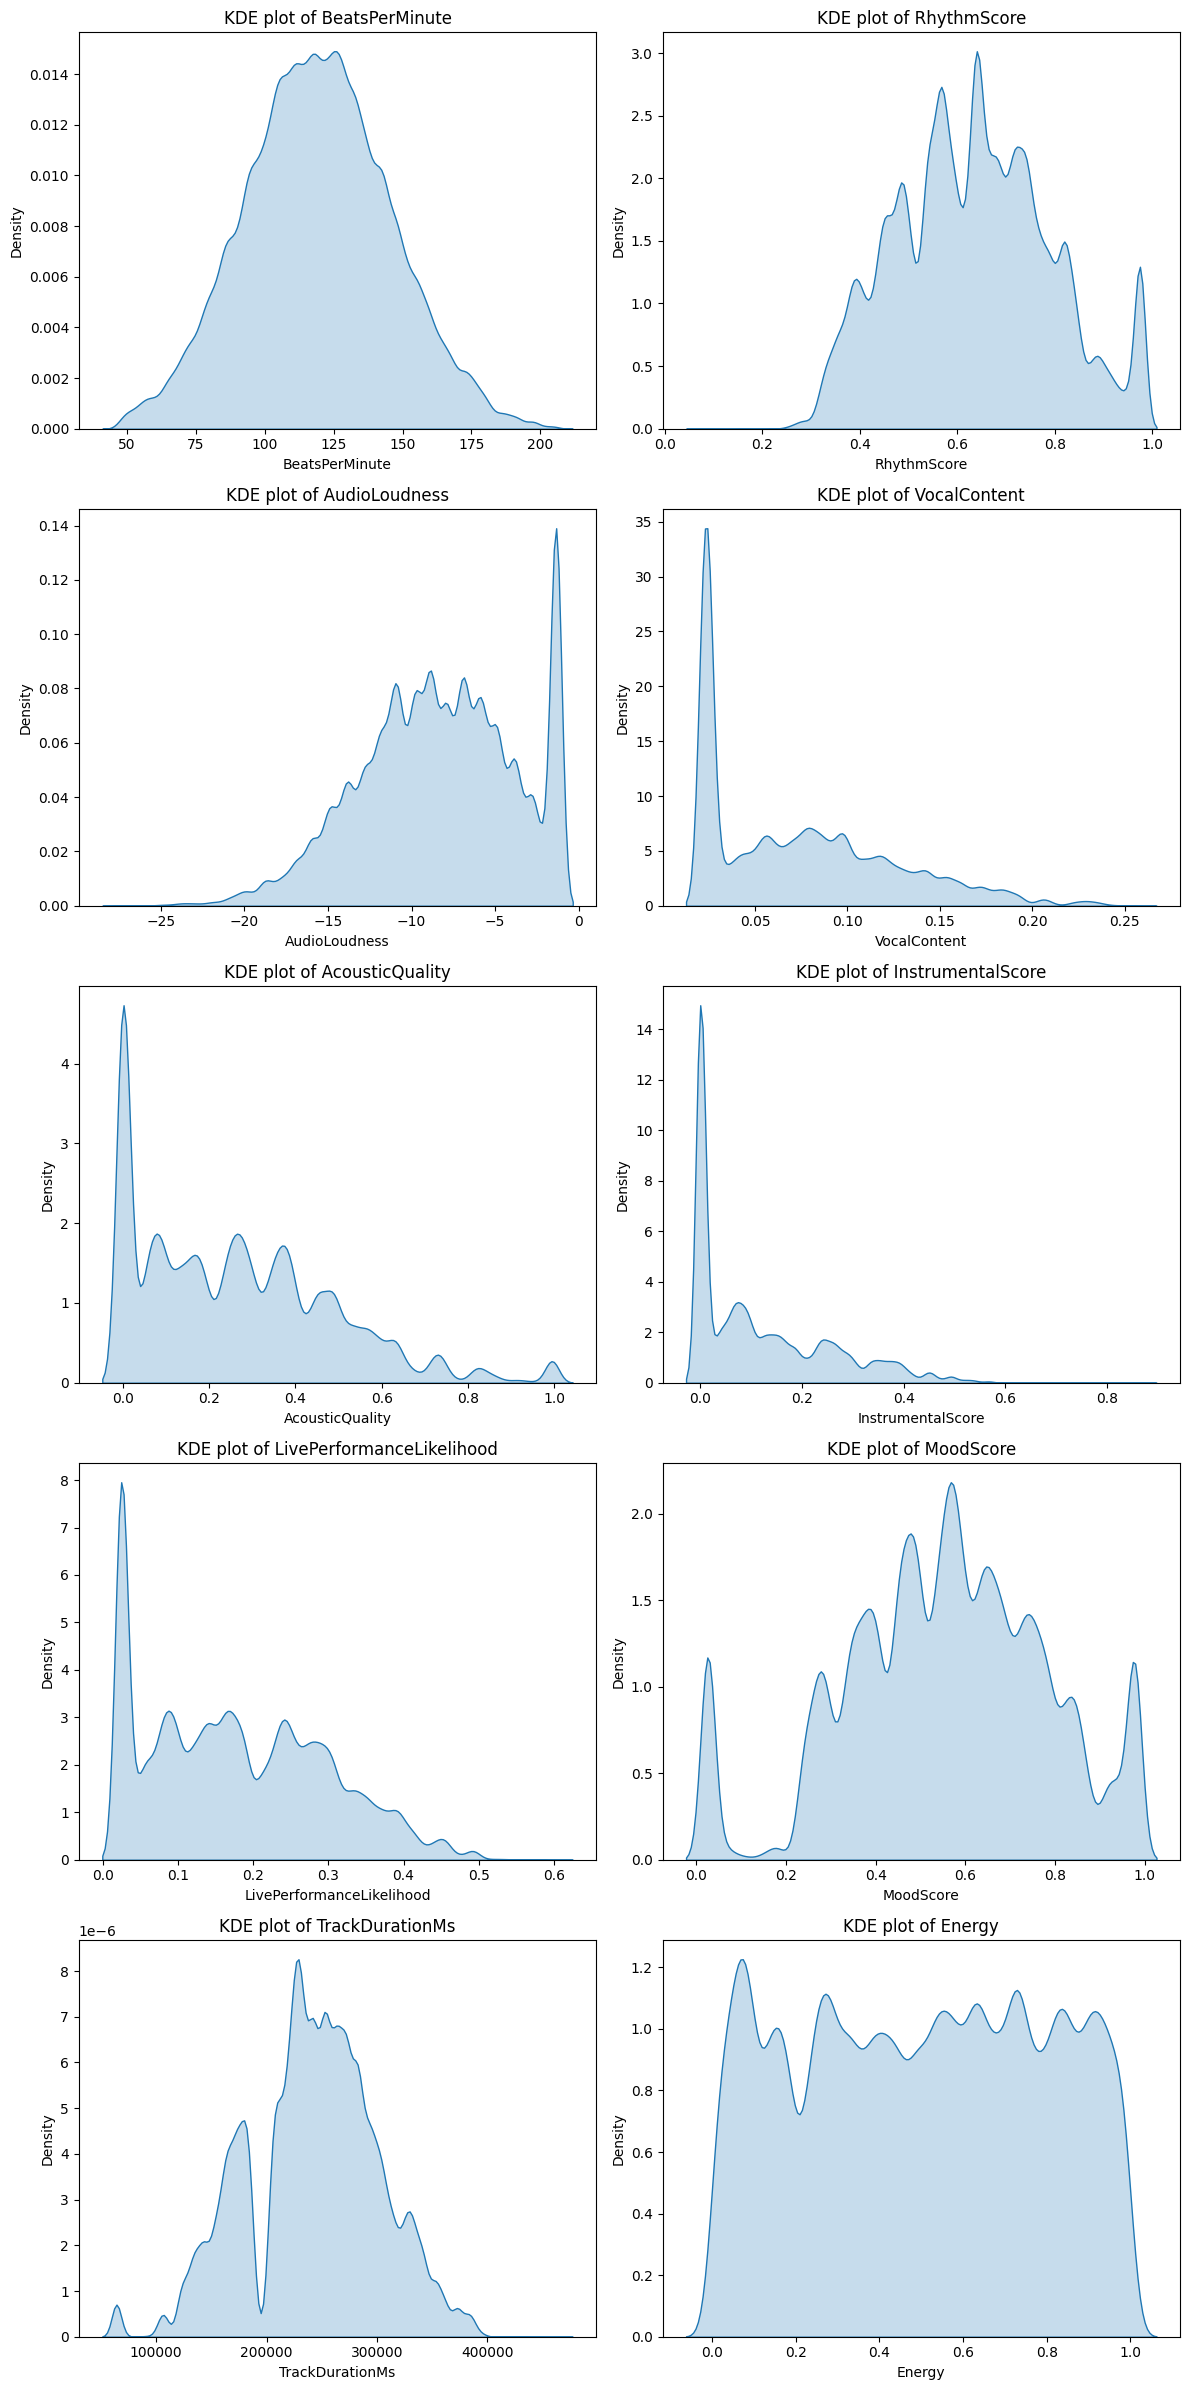

In [6]:
# KDE plots of target variable and numerical features
plt.figure(figsize=(12, 24))
kdeplot_col_names = [target_col]
kdeplot_col_names.extend(numeric_col_names)
for i, col in enumerate(kdeplot_col_names, start=1):
    plt.subplot(5, 2, i)
    sns.kdeplot(data=train_data, x=col, fill=True)
    plt.tight_layout()
    plt.title(f"KDE plot of {col}")

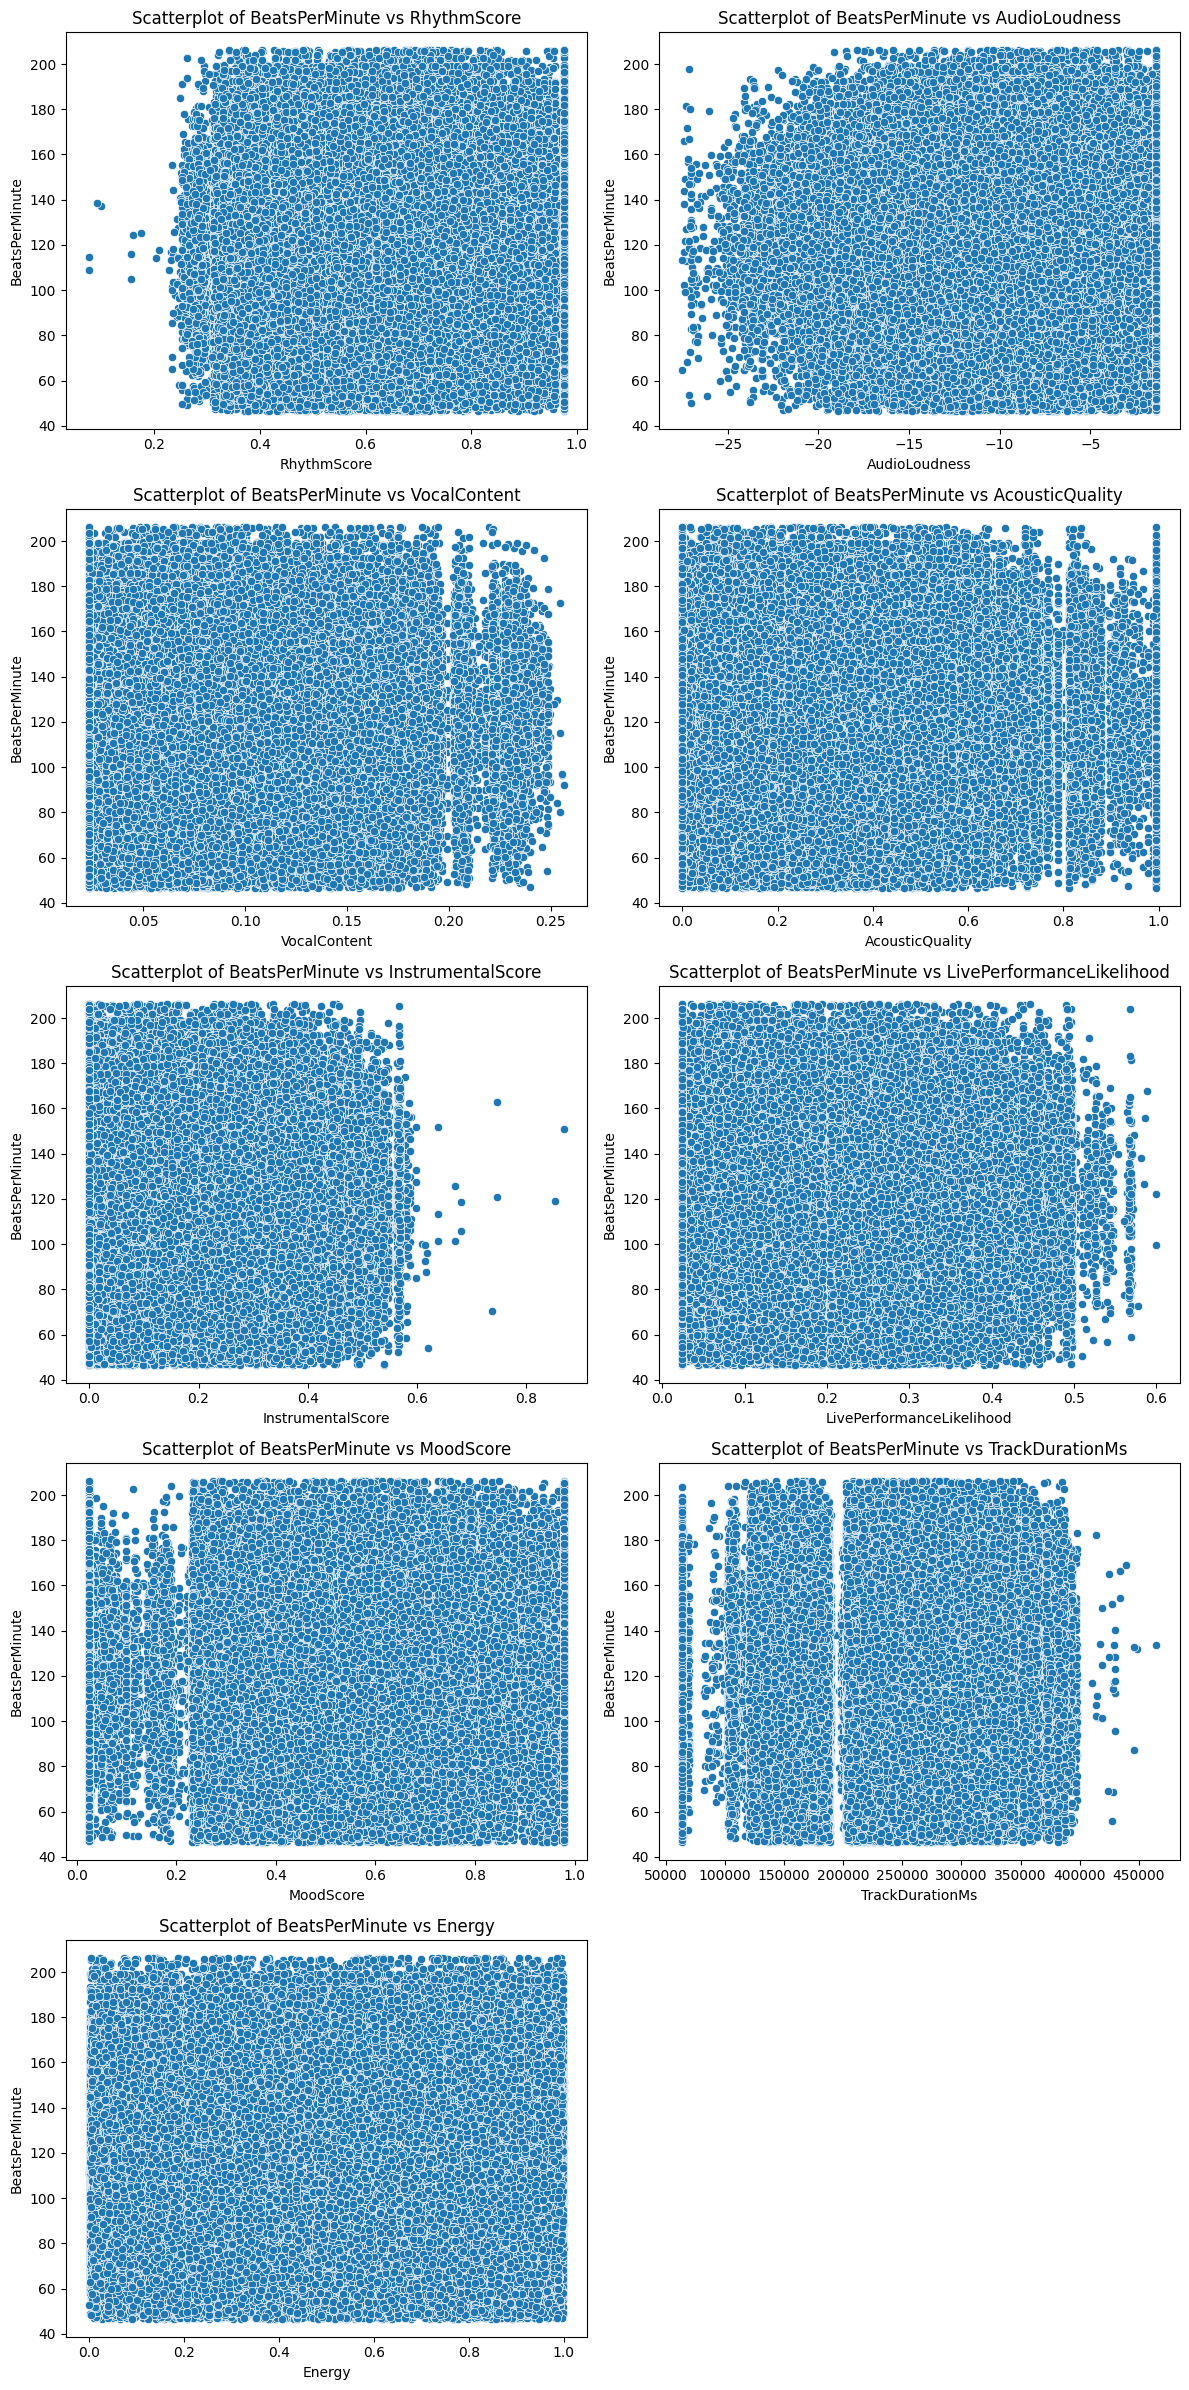

In [7]:
plt.figure(figsize=(12, 24))
for i, col in enumerate(numeric_col_names, start=1):
    plt.subplot(5, 2, i)
    sns.scatterplot(data=train_data, x=col, y="BeatsPerMinute")
    plt.tight_layout()
    plt.title(f"Scatterplot of BeatsPerMinute vs {col}")

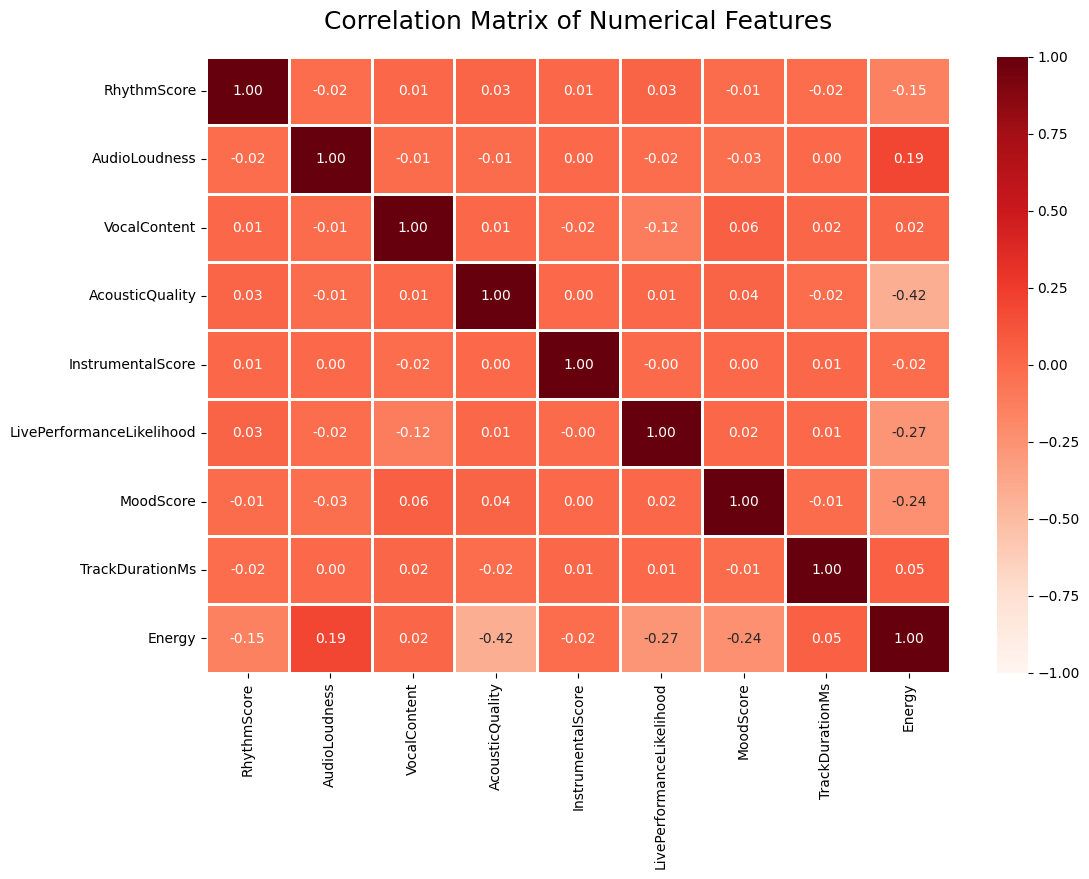

In [8]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_data[numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

# 4. Initial Setup for Stacking

We'll use stacking, an [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) strategy, to generate the predictions. As we'll need to gather predictions from various base models (a.k.a. level-0 models) to feed as input features to a meta model (a.k.a. level-1 model), in order to streamline the process of experimenting with different combinations of base models, some helper classes will be defined in this section. These classes can also be found [here](https://github.com/chuo-v/machine-learning-utils/blob/master/ensemble-learning/stacking/stacking_predictions_retriever.py) at one of my GitHub repositories used to organize some utilities I implemented for machine learning.

In [9]:
class StackingEstimator:
    """
    A class representing an estimator that will be used for stacking, an ensemble learning strategy.

    Intended to be used in conjunction with the `StackingPredictionsRetriever` class, which helps
    retrieve predictions for multiple instances of `StackingEstimator`; as the predictions are saved
    in files, on subsequent requests to retrieve predictions, even as the set of estimators has been
    modified, the `StackingPredictionsRetriever` class can determine the predictions of estimators
    that are non-stale and available (if any) by using the `get_hash` method of the `StackingEstimator`
    class to determine the relevance and staleness of any saved predictions.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimator are determinstic, i.e. they are exactly the same everytime the estimator is
    run with the same inputs (`name`, `params_dict`, `feature_names`, `get_predictions`).
    """
    name = ""
    params_dict = {}
    feature_names = []
    get_predictions = lambda: None

    def __init__(
        self,
        name: str,
        feature_names: [str],
        params_dict: {},
        get_preds: FunctionType
    ):
        """
        Initializes a new instance of `StackingEstimator`.

        :param name:
            A string representing a name for the estimator. It is used for the column names of
            the training and test predictions for each estimator, and is also used as an input
            to calculate a hash value for the estimator. It is recommended to use a different
            name from the names used for other estimators passed to `StackingPredictionsRetriever`.
        :param feature_names:
            A list of strings representing the names of the features that will be used for the
            estimator. It will be passed as an argument to `get_preds`. Internally, it is only
            used as an input to calculate a hash value for the estimator.
        :param params_dict:
            A dictionary of parameters that will be specified for the estimator. It will be
            passed as an argument to `get_preds`. Internally, it is only used as an input
            to calculate a hash value for the estimator.
        :param get_preds:
            A function for getting the predictions for the estimator. It should only take two
            arguments: 'params_dict' and 'feature_names', and should return predictions for
            the training and test data (in that order) as a tuple of two `pandas.Series`.
        """
        # parameter check
        if not isinstance(name, str):
            raise ValueError("`name` argument should be of type `str`")
        if not isinstance(feature_names, list):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should be of type `list`")
        elif not all(isinstance(feature_name, str) for feature_name in feature_names):
            raise ValueError(f"`feature_names` argument for estimator \"{name}\" should only contain instances of `str`")
        if not isinstance(params_dict, dict):
            raise ValueError(f"`params_dict` argument for estimator \"{name}\" should be of type `dict`")
        get_preds_params = inspect.signature(get_preds).parameters.values()
        get_preds_param_names = [param.name for param in get_preds_params]
        if len(get_preds_param_names) != 2:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take two arguments")
        elif "params_dict" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"params_dict\" argument")
        elif "feature_names" not in get_preds_param_names:
            raise ValueError(f"`get_preds` function for estimator \"{name}\" should take a \"feature_names\" argument")

        self.name = name
        self.feature_names = feature_names
        self.params_dict = params_dict
        self.get_preds = get_preds

    def get_hash_value(self):
        """
        Calculates and returns a hash value for the estimator using
        `name`, `feature_names` and `params_dict` as inputs.
        """
        feature_names_str = "_".join(sorted(self.feature_names))
        params_dict_str = "_".join(f"{key}-{value}" for (key, value) in sorted(self.params_dict.items()))
        hash_input_str = "_".join([self.name, feature_names_str, params_dict_str])
        md5_hash = hl.md5(hash_input_str.encode('utf-8')).hexdigest()
        return md5_hash

class StackingPredictionsRetriever:
    """
    A class for streamlining stacking (an ensemble learning strategy) that saves predictions
    from estimators to file so that when trying out different combinations of (base) estimators,
    the predictions that are not stale can be reused, saving the time of having the estimators
    make predictions again.

    Intended to be used in conjunction with the `StackingEstimator` class. The `hash_value` of
    `StackingEstimator` is used to determine the staleness and relevance of the predictions for
    an estimator. The implementation for making predictions using an estimator needs to be
    provided as a function to `get_preds` for `StackingEstimator`; when predictions need to be
    made using an estimator, this class will call `get_preds` for the `StackingEstimator` instance.

    Proper usage of this class requires one important condition to be satisfied: the predictions made
    using the estimators are determinstic, i.e. they are exactly the same everytime a
    `StackingEstimator` instance is run with the same inputs.
    """
    estimators = []
    working_dir_path = ""
    train_preds_filename = ""
    test_preds_filename = ""
    preds_save_interval = 0

    def __init__(
        self,
        estimators: [StackingEstimator],
        working_dir_path: str,
        train_preds_filename: str = "train_preds",
        test_preds_filename: str = "test_preds",
        preds_save_interval: int = 5,
    ):
        """
        Initializes a new instance of `StackingPredictionsRetriever`.

        :param estimators:
            A list of `StackingEstimator` instances for which the class will retrieve predictions.
        :param working_dir_path:
            The path for the working directory where the files with predictions will be saved.
        :param train_preds_filename:
            The name of the file in which predictions for the training set will be stored.
        :param test_preds_filename:
            The name of the file in which predictions for the test set will be stored.
        :param preds_save_interval:
            An integer which specifies the interval at which predictions will be saved when
            `get_preds` is called, corresponding to the number of estimators whose predictions
            have been retrieved since the predictions were previously saved. Any estimators
            whose predictions are not stale and therefore were not required to make predictions
            again are not included in this number.
        """
        # parameter check
        if not isinstance(estimators, list):
            raise ValueError("`estimators` must be passed as a list")
        if not all(isinstance(e, StackingEstimator) for e in estimators):
            raise ValueError("`estimators` should only contain instances of `StackingEstimator`")
        if not isinstance(working_dir_path, str):
            raise ValueError("`working_dir_path` argument should be of type `str`")
        if not isinstance(preds_save_interval, int):
            raise ValueError("`preds_save_interval` argument should be of type `int`")

        self.estimators = estimators
        self.working_dir_path = working_dir_path
        self.train_preds_filename = train_preds_filename
        self.test_preds_filename = test_preds_filename
        self.preds_save_interval = preds_save_interval

    def get_train_preds_file_path(self):
        """
        Returns the file path for storing predictions for training data.
        """
        return Path(f"{self.working_dir_path}/{self.train_preds_filename}.csv")

    def get_test_preds_file_path(self):
        """
        Returns the file path for storing predictions for test data.
        """
        return Path(f"{self.working_dir_path}/{self.test_preds_filename}.csv")

    def get_current_train_and_test_preds(self):
        """
        Returns the current predictions for training and test data (in that order)
        as a tuple of two `pandas.DataFrame`.

        The predictions are attempted to be retrieved from the file paths returned
        by `get_train_preds_file_path` and `get_test_preds_file_path`; if there are
        any issues with doing so (e.g. file does not exist, dataframe is empty),
        empty dataframes will be returned instead.
        In the case an `pandas.errors.EmptyDataError` exception is raised when
        reading from a file, the corresponding file will be removed.
        """
        curr_train_preds = pd.DataFrame()
        curr_test_preds = pd.DataFrame()
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            try:
                curr_train_preds = pd.read_csv(train_preds_file_path)
            except pd.errors.EmptyDataError:
                train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            try:
                curr_test_preds = pd.read_csv(test_preds_file_path)
            except pd.errors.EmptyDataError:
                test_preds_file_path.unlink()

        return curr_train_preds, curr_test_preds

    def get_preds(self):
        """
        Retrieves predictions from all estimators in `estimators`, storing them in
        two files at the file paths specified by `working_dir_path`,
        `train_preds_filename` and `test_preds_filename`.

        If non-stale (relevant) predictions are found for an estimator, retrieval
        of predictions by calling `get_preds` on the estimator will be skipped,
        and the existing predictions for the estimator will be kept.
        """
        print("[INFO] Getting predictions..")
        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        preds_retrieved_count = 0
        num_preds_retrieved_but_not_yet_saved = 0
        estimators_skipped = []

        for estimator in self.estimators:
            estimator_hash_value = estimator.get_hash_value()
            estimator_name = f"{estimator.name} ({estimator_hash_value})"

            # skip retrieving predictions for estimator if non-stale predictions are already available
            train_preds_available = any(estimator_hash_value in col_name for col_name in curr_train_preds.columns)
            test_preds_available = any(estimator_hash_value in col_name for col_name in curr_test_preds.columns)
            if train_preds_available and test_preds_available:
                estimators_skipped += [estimator_name]
                continue

            print(f"[INFO] Getting predictions for estimator {estimator_name}")
            train_preds, test_preds = estimator.get_preds(estimator.params_dict, estimator.feature_names)
            if not isinstance(train_preds, pd.core.series.Series):
                raise ValueError("`train_preds` should be of type `pandas.Series`")
            if not isinstance(test_preds, pd.core.series.Series):
                raise ValueError("`test_preds` should be of type `pandas.Series`")
            curr_train_preds[estimator_name] = train_preds
            curr_test_preds[estimator_name] = test_preds
            preds_retrieved_count += 1

            # save predictions at an interval of `preds_save_interval`
            if preds_retrieved_count % self.preds_save_interval == 0:
                curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
                curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
                num_preds_retrieved_but_not_yet_saved = 0
                print("[INFO] Saved predictions")
            else:
                num_preds_retrieved_but_not_yet_saved += 1

        if estimators_skipped:
            estimators_skipped.sort()
            formatted_estimators = ", ".join(estimators_skipped)
            print(f"[INFO] Skipped retrieving predictions for following estimators as their current ones are not stale:\n{formatted_estimators}")

        if num_preds_retrieved_but_not_yet_saved != 0:
            curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
            curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
            print("[INFO] Saved predictions")

        print("[INFO] Finished getting all predictions")

    def sync_preds(self):
        """
        Syncs the predictions stored at the two file paths specified by
        `working_dir_path`, `train_preds_filename` and `test_preds_filename` by
        removing predictions for any estimator that is not currently in `estimators`.

        Note that new predictions for estimators that do not currently have predictions
        in the files will not be added; `get_preds` should be used for this purpose
        instead.
        """
        print("[INFO] Syncing predictions..")
        estimator_hash_values = [estimator.get_hash_value() for estimator in self.estimators]
        should_remove_col = lambda col_name: not any(hash_value in col_name for hash_value in estimator_hash_values)

        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()

        if not curr_train_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_train_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from training predictions:\n{col_names_to_remove}")
                curr_train_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_train_preds.to_csv(self.get_train_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for training predictions were dropped")
        if not curr_test_preds.empty:
            col_names_to_remove = [col_name for col_name in curr_test_preds.columns if should_remove_col(col_name)]
            if col_names_to_remove:
                print(f"[INFO] Dropping columns for following estimators from test predictions:\n{col_names_to_remove}")
                curr_test_preds.drop(columns=col_names_to_remove, inplace=True)
                curr_test_preds.to_csv(self.get_test_preds_file_path(), index=False)
            else:
                print(f"[INFO] No columns for test predictions were dropped")

        print("[INFO] Finished syncing predictions")

    def import_preds(self, input_dir_path):
        """
        Imports predictions stored at the two file paths at `input_dir_path` with
        `train_preds_filename` and `test_preds_filename` as their filenames. If no
        such files are found, no predictions will be imported.

        Only predictions for estimators specified in `estimators` will be imported.
        Any predictions for estimators that were already available will be overwritten
        with predictions for the same estimators found in the files at `input_dir_path`.

        :param input_dir_path:
            The path to the directory for the training and test predictions files.
            The file names are expected to be the same as `train_preds_filename`
            and `test_preds_filename`
        """
        print("[INFO] Importing predictions..")
        curr_train_preds, curr_test_preds = self.get_current_train_and_test_preds()
        input_train_preds = pd.DataFrame()
        input_test_preds = pd.DataFrame()

        input_train_preds_path = Path(f"{input_dir_path}/{self.train_preds_filename}.csv")
        input_test_preds_path = Path(f"{input_dir_path}/{self.test_preds_filename}.csv")
        if input_train_preds_path.is_file():
            try:
                input_train_preds = pd.read_csv(input_train_preds_path)
            except: pass
        if input_test_preds_path.is_file():
            try:
                input_test_preds = pd.read_csv(input_test_preds_path)
            except: pass

        estimators_with_imported_train_preds = []
        estimators_with_imported_test_preds = []
        for estimator in self.estimators:
            estimator_hash_value = estimator.get_hash_value()
            estimator_name = f"{estimator.name} ({estimator_hash_value})"
            train_preds_available = any(estimator_hash_value in col_name for col_name in input_train_preds.columns)
            test_preds_available = any(estimator_hash_value in col_name for col_name in input_test_preds.columns)

            if train_preds_available:
                curr_train_preds[estimator_name] = input_train_preds[estimator_name]
                estimators_with_imported_train_preds += [estimator_name]
            if test_preds_available:
                curr_test_preds[estimator_name] = input_test_preds[estimator_name]
                estimators_with_imported_test_preds += [estimator_name]

        if not estimators_with_imported_train_preds:
            print("[INFO] No train predictions were imported")
        else:
            curr_train_preds.sort_index(axis=1).to_csv(self.get_train_preds_file_path(), index=False)
            formatted_estimators = ", ".join(estimators_with_imported_train_preds)
            print(f"[INFO] {len(estimators_with_imported_train_preds)} train predictions were imported:\n{formatted_estimators}")
        if not estimators_with_imported_test_preds:
            print("[INFO] No test predictions were imported")
        else:
            curr_test_preds.sort_index(axis=1).to_csv(self.get_test_preds_file_path(), index=False)
            formatted_estimators = ", ".join(estimators_with_imported_test_preds)
            print(f"[INFO] {len(estimators_with_imported_test_preds)} test predictions were imported:\n{formatted_estimators}")
        
        print("[INFO] Finished importing predictions")

    def clear_preds(self):
        """
        Removes all stored predictions by deleting the two files at filepaths specified
        by `working_dir_path`, `train_preds_filename` and `test_preds_filename`.
        """
        train_preds_file_path = self.get_train_preds_file_path()
        test_preds_file_path = self.get_test_preds_file_path()

        if train_preds_file_path.is_file():
            train_preds_file_path.unlink()
        if test_preds_file_path.is_file():
            test_preds_file_path.unlink()

        print("[INFO] Finished clearing predictions")

Next, we'll simply create a variable for storing the estimators (`StackingEstimator` instances) that we'll pass to the `StackingPredictionsRetriever` class for getting all the predictions from our base models.

In [10]:
estimators = []

# 5. Data Preprocessing

## 5.1 Feature Set Study

In [11]:
# to skip feature set study when it's not needed; set to `False` to do the study
SKIP_FEATURE_SET_OPTUNA_STUDY = True

# maximum number of trials Optuna will conduct for the optimization
FEATURE_SET_OPTUNA_STUDY_NUM_TRIALS = 200

# number of splits to use for K-Fold Cross-Validation
FEATURE_SET_OPTUNA_STUDY_KFOLD_NUM_SPLITS = 5

In [12]:
def feature_set_optuna_study_objective(trial):
    trial_feature_set = [] # feature set to use for this trial

    for i in range(len(optuna_study_original_features)):
        suggestion_choices = [optuna_study_original_features[i]] + ["none"]
        feature = trial.suggest_categorical(f"original_feature_{i+1}", suggestion_choices)
        if feature != "none" and feature not in trial_feature_set: # ignore dummy feature and filter out duplicates
            trial_feature_set += [feature]

    for i in range(len(optuna_study_all_interaction_features)):
        suggestion_choices = [optuna_study_all_interaction_features[i]] + ["none"]
        feature = trial.suggest_categorical(f"interaction_feature_{i+1}", suggestion_choices)
        if feature != "none" and feature not in trial_feature_set: # ignore dummy feature and filter out duplicates
            trial_feature_set += [feature]

    # if no features were chosen, return an arbitrary large value to discourage this from happening in subsequent trials
    if not trial_feature_set:
        return 1e10
    
    oof_predictions = np.zeros(len(optuna_study_train_data))

    for random_seed in RANDOM_SEEDS:
        kfold = KFold(n_splits=FEATURE_SET_OPTUNA_STUDY_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        kfold_splits = kfold.split(optuna_study_train_data.drop(target_col, axis=1), optuna_study_train_data[target_col])
        kfold_splits_enumeration = enumerate(kfold_splits)
    
        for fold, (train_indices, validation_indices) in kfold_splits_enumeration:
            X_train_fold = optuna_study_train_data[trial_feature_set].iloc[train_indices]
            y_train_fold = optuna_study_train_data[target_col].iloc[train_indices]
            X_validation_fold = optuna_study_train_data[trial_feature_set].iloc[validation_indices]
            y_validation_fold = optuna_study_train_data[target_col].iloc[validation_indices]
    
            xgb_regressor = XGBRegressor(
                n_estimators=400,
                learning_rate=0.01,
                max_depth=4,
                subsample=0.9,
                colsample_bytree=0.8,
                alpha=30,
                gamma=30,
                reg_lambda=30,
                eval_metric="rmse",
                n_jobs=-1,
                random_state=RANDOM_SEEDS[0]
            )
            xgb_regressor.fit(X_train_fold, y_train_fold)
            oof_predictions[validation_indices] += np.array(xgb_regressor.predict(X_validation_fold)) / len(RANDOM_SEEDS)

    return np.sqrt(mean_squared_error(oof_predictions, optuna_study_train_data[target_col]))

In [13]:
if SKIP_FEATURE_SET_OPTUNA_STUDY:
    print("Skipped feature set study")
else:
    print("Started feature set study")
    optuna_study_train_data = train_data.copy()
    optuna_study_original_features = numeric_col_names.to_list()
    
    optuna_study_all_interaction_features = []
    optuna_study_all_interaction_feature_pairs = list(combinations(numeric_col_names, 2))
    for feature_pair in optuna_study_all_interaction_feature_pairs:
        interaction_feature_train = optuna_study_train_data[feature_pair[0]] * optuna_study_train_data[feature_pair[1]]
        # square root interaction features
        sqrt_interaction_feature_name = f"sqrt_{feature_pair[0]}_x_{feature_pair[1]}"
        optuna_study_all_interaction_features += [sqrt_interaction_feature_name]
        optuna_study_train_data[sqrt_interaction_feature_name] = np.sign(interaction_feature_train) * np.sqrt(interaction_feature_train.abs())
    
    sampler = optuna.samplers.TPESampler(n_ei_candidates=128)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    study.optimize(feature_set_optuna_study_objective, n_trials=FEATURE_SET_OPTUNA_STUDY_NUM_TRIALS)

Skipped feature set study


## 5.2 Prepare Feature Sets

In [14]:
# original features
original_features = numeric_col_names

# interaction features
interaction_features = []
all_interaction_feature_pairs = list(combinations(numeric_col_names, 2))
for feature_pair in all_interaction_feature_pairs:
    interaction_feature_train = train_data[feature_pair[0]] * train_data[feature_pair[1]]
    interaction_feature_test = test_data[feature_pair[0]] * test_data[feature_pair[1]]
    # square root interaction features
    sqrt_interaction_feature_name = f"sqrt_{feature_pair[0]}_x_{feature_pair[1]}"
    interaction_features += [sqrt_interaction_feature_name]
    train_data[sqrt_interaction_feature_name] = np.sign(interaction_feature_train) * np.sqrt(interaction_feature_train.abs())
    test_data[sqrt_interaction_feature_name] = np.sign(interaction_feature_test) * np.sqrt(interaction_feature_train.abs())

In [15]:
# original features
base_feature_set = original_features.to_list()

# feature set with a mix of original (7) and square-rooted interaction (7) features
feature_set_2 = [
    # original features
    "Energy", "TrackDurationMs", "AcousticQuality",
    "MoodScore", "RhythmScore", "VocalContent",
    "AudioLoudness",
    # square-rooted interaction features
    "sqrt_InstrumentalScore_x_Energy", "sqrt_AcousticQuality_x_LivePerformanceLikelihood",
    "sqrt_RhythmScore_x_LivePerformanceLikelihood", "sqrt_AudioLoudness_x_Energy",
    "sqrt_MoodScore_x_TrackDurationMs",
]

# feature set with a mix of original (6) and square-rooted interaction (3) features
feature_set_3 = [
    # original features
    "MoodScore", "VocalContent", "InstrumentalScore", "RhythmScore", "Energy",
    "TrackDurationMs",
    # square-rooted interaction features
    "sqrt_AudioLoudness_x_MoodScore", "sqrt_AcousticQuality_x_MoodScore",
    "sqrt_RhythmScore_x_AudioLoudness",
]

# feature set with a mix of original (7) and square-rooted interaction (9) features
feature_set_4 = [
    # original features
    "AudioLoudness", "Energy", "MoodScore", "RhythmScore", "TrackDurationMs",
    "VocalContent", "LivePerformanceLikelihood",
    # square-rooted interaction features
    "sqrt_AudioLoudness_x_AcousticQuality", "sqrt_AudioLoudness_x_LivePerformanceLikelihood",
    "sqrt_AudioLoudness_x_MoodScore", "sqrt_AcousticQuality_x_LivePerformanceLikelihood",
    "sqrt_InstrumentalScore_x_MoodScore", "sqrt_InstrumentalScore_x_TrackDurationMs",
    "sqrt_LivePerformanceLikelihood_x_TrackDurationMs", "sqrt_MoodScore_x_TrackDurationMs",
    "sqrt_VocalContent_x_MoodScore",
]

# feature set with a mix of original (6) and square-rooted interaction (8) features
feature_set_5 = [
    # original features
    "VocalContent", "AudioLoudness", "TrackDurationMs", "AcousticQuality", "RhythmScore",
    "MoodScore",
    # square-rooted interaction features
    "sqrt_AudioLoudness_x_MoodScore", "sqrt_AudioLoudness_x_Energy",
    "sqrt_TrackDurationMs_x_Energy", "sqrt_AcousticQuality_x_LivePerformanceLikelihood",
    "sqrt_RhythmScore_x_AcousticQuality", "sqrt_MoodScore_x_Energy",
    "sqrt_InstrumentalScore_x_Energy", "sqrt_AcousticQuality_x_Energy",
]

# 6. Hyperparameter Tuning (Base Models)

In the next section, we'll specify the base models for stacking, so in this section, we'll take a look first at some optimal hyperparameter combinations to use for the base models.

In [16]:
# to skip hyperparameter tuning when it's not needed; set to `False` to do the tuning
SKIP_BASE_MODEL_HYPERPARAMETER_TUNING = True

In [17]:
class BaseModelOptunaStudyEstimator(Enum):
    XGBREGRESSOR = "XGBRegressor"

Manually configure the values for the following variables for different studies.

In [18]:
# estimator to use for the study
BASE_MODEL_OPTUNA_STUDY_ESTIMATOR = BaseModelOptunaStudyEstimator.XGBREGRESSOR

# feature set to use for the study
BASE_MODEL_OPTUNA_STUDY_FEATURE_SET = feature_set_2

# maximum number of trials Optuna will conduct for the optimization
BASE_MODEL_OPTUNA_STUDY_NUM_TRIALS = 50

# number of splits to use for K-Fold Cross-Validation
BASE_MODEL_KFOLD_NUM_SPLITS = 5

In [19]:
def get_base_model_optuna_params(trial, study_estimator):
    if study_estimator == BaseModelOptunaStudyEstimator.XGBREGRESSOR:
        return {
            "n_estimators": trial.suggest_int("n_estimators", 20, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
            "max_depth": trial.suggest_int("max_depth", 2, 4),
            "subsample": trial.suggest_float("subsample", 0.4, 1),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            "alpha": trial.suggest_float("alpha", 0.0, 150.0),
            "gamma": trial.suggest_float("gamma", 0.0, 150.0),
            "lambda": trial.suggest_float("lambda", 0.0, 150.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 30),
        }
    else:
        raise ValueError("Unsupported optuna study estimator")

def get_base_model_optuna_oof_predictions(study_estimator, trial_params, X_train_fold, y_train_fold, X_validation_fold):    
    if study_estimator == BaseModelOptunaStudyEstimator.XGBREGRESSOR:
        xgb_regressor = XGBRegressor(
            n_estimators=trial_params["n_estimators"],
            learning_rate=trial_params["learning_rate"],
            max_depth=trial_params["max_depth"],
            subsample=trial_params["subsample"],
            colsample_bytree=trial_params["colsample_bytree"],
            alpha=trial_params["alpha"],
            gamma=trial_params["gamma"],
            reg_lambda=trial_params["lambda"],
            min_child_weight=trial_params["min_child_weight"],
            eval_metric="rmse",
            n_jobs=-1,
            random_state=RANDOM_SEEDS[0]
        )
        xgb_regressor.fit(X_train_fold, y_train_fold)
        return np.array(xgb_regressor.predict(X_validation_fold))
    else:
        raise ValueError("Unsupported optuna study estimator")

def base_model_optuna_study_objective(trial):
    # get base model hyperparameters
    base_model_params = get_base_model_optuna_params(trial, BASE_MODEL_OPTUNA_STUDY_ESTIMATOR)
    # OOF predictions that will be used to calculate RMSE
    oof_predictions = np.zeros(len(train_data))

    # conduct CV using multiple random seeds
    for random_seed in RANDOM_SEEDS:
        kfold = KFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        kfold_splits = kfold.split(train_data.drop(target_col, axis=1), train_data[target_col])
        kfold_splits_enumeration = enumerate(kfold_splits)
    
        for fold, (train_indices, validation_indices) in kfold_splits_enumeration:
            X_train_fold = train_data[BASE_MODEL_OPTUNA_STUDY_FEATURE_SET].iloc[train_indices]
            y_train_fold = train_data[target_col].iloc[train_indices]
            X_validation_fold = train_data[BASE_MODEL_OPTUNA_STUDY_FEATURE_SET].iloc[validation_indices]
            y_validation_fold = train_data[target_col].iloc[validation_indices]
            oof_predictions_fold = get_base_model_optuna_oof_predictions(
                BASE_MODEL_OPTUNA_STUDY_ESTIMATOR, base_model_params, X_train_fold, y_train_fold, X_validation_fold
            )
            oof_predictions[validation_indices] += oof_predictions_fold / len(RANDOM_SEEDS)

    return np.sqrt(mean_squared_error(oof_predictions, train_data[target_col]))

In [20]:
if SKIP_BASE_MODEL_HYPERPARAMETER_TUNING:
    print("Skipped base model hyperparameter tuning")
else:
    print(f"Started base model hyperparameter tuning for {BASE_MODEL_OPTUNA_STUDY_ESTIMATOR.value} using the following feature set:\n{BASE_MODEL_OPTUNA_STUDY_FEATURE_SET}")
    sampler = optuna.samplers.TPESampler(n_ei_candidates=128)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    study.optimize(base_model_optuna_study_objective, n_trials=BASE_MODEL_OPTUNA_STUDY_NUM_TRIALS)
    
    print(f"# trials finished: {len(study.trials)}")
    trial = study.best_trial
    print(f"Best trial RMSE: {trial.value}")
    print(f"Best trial params:")
    for param_key, param_value in trial.params.items():
        print(f"- {param_key}: {param_value}")

Skipped base model hyperparameter tuning


# 7. Base Models

## 7.1 LinearRegression

### 7.1.1 Helper Methods (LinearRegression)

In [21]:
def get_preds_linearregression(params_dict, feature_names):
    oof_predictions = np.zeros(len(train_data))
    test_predictions = np.zeros(len(test_data))

    kfold = KFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=RANDOM_SEEDS[0])
    kfold_splits = kfold.split(train_data.drop(target_col, axis=1), train_data[target_col])
    kfold_splits_enumeration = enumerate(kfold_splits)

    for fold, (train_indices, validation_indices) in kfold_splits_enumeration:
        X_train_fold = train_data[feature_names].iloc[train_indices]
        y_train_fold = train_data[target_col].iloc[train_indices]
        X_validation_fold = train_data[feature_names].iloc[validation_indices]
        y_validation_fold = train_data[target_col].iloc[validation_indices]

        lr = LinearRegression(n_jobs=params_dict["n_jobs"])
        lr.fit(X_train_fold, y_train_fold)

        # get oof predictions
        validation_predictions_fold = lr.predict(X_validation_fold)
        oof_predictions[validation_indices] = np.array(validation_predictions_fold)

        # get test predictions
        test_predictions_fold = lr.predict(test_data[feature_names])
        test_predictions += np.array(test_predictions_fold) / BASE_MODEL_KFOLD_NUM_SPLITS

    return pd.Series(oof_predictions), pd.Series(test_predictions)

### 7.1.2 Add Estimators (LinearRegression)

Add LinearRegression estimator to list that StackingPredictionsRetriever will process.

In [22]:
estimators += [
    StackingEstimator(
        name="LinearRegression_1",
        params_dict={ "n_jobs": -1 },
        feature_names=base_feature_set,
        get_preds=get_preds_linearregression
    ),
]

## 7.2 XGBRegressor

### 7.2.1 Helper Methods (XGBRegressor)

In [23]:
def get_xgbregressor_preds(params_dict, feature_names):
    oof_predictions = np.zeros(len(train_data))
    test_predictions = np.zeros(len(test_data))

    kfold = KFold(n_splits=BASE_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=RANDOM_SEEDS[0])
    kfold_splits = kfold.split(train_data.drop(target_col, axis=1), train_data[target_col])
    kfold_splits_enumeration = enumerate(kfold_splits)

    for fold, (train_indices, validation_indices) in kfold_splits_enumeration:
        X_train_fold = train_data[feature_names].iloc[train_indices]
        y_train_fold = train_data[target_col].iloc[train_indices]
        X_validation_fold = train_data[feature_names].iloc[validation_indices]
        y_validation_fold = train_data[target_col].iloc[validation_indices]

        xgb_regressor = XGBRegressor(
            n_estimators=params_dict["n_estimators"],
            learning_rate=params_dict["learning_rate"],
            max_depth=params_dict["max_depth"],
            subsample=params_dict["subsample"],
            colsample_bytree=params_dict["colsample_bytree"],
            alpha=params_dict["alpha"],
            gamma=params_dict["gamma"],
            reg_lambda=params_dict["lambda"],
            min_child_weight=params_dict["min_child_weight"],
            eval_metric=params_dict["eval_metric"],
            n_jobs=params_dict["n_jobs"],
            random_state=params_dict["random_state"]
        )
        xgb_regressor.fit(X_train_fold, y_train_fold)

        # get oof predictions
        validation_predictions_fold = xgb_regressor.predict(X_validation_fold)
        oof_predictions[validation_indices] = np.array(validation_predictions_fold)

        # get test predictions
        test_predictions_fold = xgb_regressor.predict(test_data[feature_names])
        test_predictions += np.array(test_predictions_fold) / BASE_MODEL_KFOLD_NUM_SPLITS

    return pd.Series(oof_predictions), pd.Series(test_predictions)

def get_xgbregressor_stacking_estimator(index, params_dict, feature_names):
    params_dict["n_jobs"] = -1
    params_dict["eval_metric"] = "rmse"
    params_dict["random_state"] = RANDOM_SEEDS[0]
    return StackingEstimator(
        name=f"XGBRegressor_{index}",
        params_dict=params_dict,
        feature_names=feature_names,
        get_preds=get_xgbregressor_preds
    )

### 7.2.2 Add Estimators (XGBRegressor)

Add XGBRegressor estimators to list that StackingPredictionsRetriever will process. Hyperparameters were found using Optuna.

In [24]:
# add XGBRegressor estimators using base_feature_set
estimators += [
    get_xgbregressor_stacking_estimator(
        index=1,
        params_dict={
            "n_estimators": 419,
            "learning_rate": 0.00873,
            "max_depth": 4,
            "subsample": 0.86035,
            'colsample_bytree': 0.98194,
            "alpha": 39.829,
            "gamma": 5.8215,
            "lambda": 16.945,
            "min_child_weight": 14,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=2,
        params_dict={
            "n_estimators": 520,
            "learning_rate": 0.007,
            "max_depth": 4,
            "subsample": 0.84,
            'colsample_bytree': 0.65,
            "alpha": 49.8,
            "gamma": 41.5,
            "lambda": 17.3,
            "min_child_weight": 10,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=3,
        params_dict={
            "n_estimators": 126,
            "learning_rate": 0.03378763839643197,
            "max_depth": 3,
            "subsample": 0.8109936128273788,
            'colsample_bytree': 0.6186370997220908,
            "alpha": 23.99918347861851,
            "gamma": 8.844917564553814,
            "lambda": 39.04810493605068,
            "min_child_weight": 2,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=4,
        params_dict={
            "n_estimators": 290,
            "learning_rate": 0.01185,
            "max_depth": 4,
            "subsample": 0.68831,
            'colsample_bytree': 0.63104,
            "alpha": 3.8025,
            "gamma": 24.200,
            "lambda": 20.248,
            "min_child_weight": 4,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=5,
        params_dict={
            "n_estimators": 574,
            "learning_rate": 0.00605,
            "max_depth": 5,
            "subsample": 0.59859,
            'colsample_bytree': 0.95745,
            "alpha": 34.301,
            "gamma": 50.374,
            "lambda": 62.361,
            "min_child_weight": 1,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=6,
        params_dict={
            "n_estimators": 359,
            "learning_rate": 0.01010,
            "max_depth": 5,
            "subsample": 0.81285,
            'colsample_bytree': 0.96021,
            "alpha": 96.249,
            "gamma": 67.071,
            "lambda": 57.520,
            "min_child_weight": 5,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=7,
        params_dict={
            "n_estimators": 689,
            "learning_rate": 0.00415,
            "max_depth": 5,
            "subsample": 0.78507,
            'colsample_bytree': 0.90591,
            "alpha": 42.216,
            "gamma": 36.752,
            "lambda": 47.488,
            "min_child_weight": 2,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=8,
        params_dict={
            "n_estimators": 564,
            "learning_rate": 0.00801,
            "max_depth": 4,
            "subsample": 0.63157,
            'colsample_bytree': 0.57284,
            "alpha": 31.146,
            "gamma": 106.48,
            "lambda": 9.4569,
            "min_child_weight": 3,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=9,
        params_dict={
            "n_estimators": 358,
            "learning_rate": 0.00842,
            "max_depth": 5,
            "subsample": 0.82558,
            'colsample_bytree': 0.77944,
            "alpha": 97.697,
            "gamma": 56.345,
            "lambda": 37.812,
            "min_child_weight": 6,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=10,
        params_dict={
            "n_estimators": 782,
            "learning_rate": 0.007316306525223049,
            "max_depth": 3,
            "subsample": 0.7895612293410138,
            'colsample_bytree': 0.7222765453478481,
            "alpha": 4.160712998993395,
            "gamma": 47.079142995272285,
            "lambda": 36.61221684670636,
            "min_child_weight": 7,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=11,
        params_dict={
            "n_estimators": 240,
            "learning_rate": 0.02066,
            "max_depth": 3,
            "subsample": 0.86332,
            'colsample_bytree': 0.87684,
            "alpha": 35.458,
            "gamma": 36.509,
            "lambda": 35.474,
            "min_child_weight": 3,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=12,
        params_dict={
            "n_estimators": 369,
            "learning_rate": 0.01826,
            "max_depth": 3,
            "subsample": 0.92574,
            'colsample_bytree': 0.86274,
            "alpha": 11.235,
            "gamma": 17.383,
            "lambda": 38.746,
            "min_child_weight": 8,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=13,
        params_dict={
            "n_estimators": 194,
            "learning_rate": 0.02746,
            "max_depth": 3,
            "subsample": 0.71651,
            'colsample_bytree': 0.71002,
            "alpha": 40.65526,
            "gamma": 0.06232,
            "lambda": 42.77455,
            "min_child_weight": 14,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=14,
        params_dict={
            "n_estimators": 250,
            "learning_rate": 0.01286,
            "max_depth": 4,
            "subsample": 0.80051,
            'colsample_bytree': 0.90229,
            "alpha": 15.849,
            "gamma": 10.232,
            "lambda": 40.727,
            "min_child_weight": 4,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=15,
        params_dict={
            "n_estimators": 163,
            "learning_rate": 0.02103,
            "max_depth": 4,
            "subsample": 0.97774,
            'colsample_bytree': 0.75990,
            "alpha": 49.618,
            "gamma": 30.539,
            "lambda": 27.296,
            "min_child_weight": 9,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=16,
        params_dict={
            "n_estimators": 498,
            "learning_rate": 0.00806,
            "max_depth": 4,
            "subsample": 0.57032,
            'colsample_bytree': 0.99467,
            "alpha": 7.2142,
            "gamma": 43.194,
            "lambda": 46.745,
            "min_child_weight": 12,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=17,
        params_dict={
            "n_estimators": 143,
            "learning_rate": 0.09416,
            "max_depth": 2,
            "subsample": 0.85327,
            'colsample_bytree': 0.87458,
            "alpha": 46.719,
            "gamma": 17.685,
            "lambda": 39.986,
            "min_child_weight": 19,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=18,
        params_dict={
            "n_estimators": 50,
            "learning_rate": 0.06304,
            "max_depth": 4,
            "subsample": 0.83493,
            'colsample_bytree': 0.81157,
            "alpha": 3.6707,
            "gamma": 0.56875,
            "lambda": 0.40834,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=19,
        params_dict={
            "n_estimators": 328,
            "learning_rate": 0.02161,
            "max_depth": 3,
            "subsample": 0.80907,
            'colsample_bytree': 0.94205,
            "alpha": 6.1269,
            "gamma": 10.642,
            "lambda": 20.197,
            "min_child_weight": 2,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=20,
        params_dict={
            "n_estimators": 358,
            "learning_rate": 0.01723,
            "max_depth": 3,
            "subsample": 0.72286,
            'colsample_bytree': 0.81883,
            "alpha": 31.111,
            "gamma": 21.155,
            "lambda": 20.569,
            "min_child_weight": 9,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=21,
        params_dict={
            "n_estimators": 258,
            "learning_rate": 0.01756,
            "max_depth": 4,
            "subsample": 0.63591,
            'colsample_bytree': 0.70695,
            "alpha": 48.174,
            "gamma": 31.756,
            "lambda": 33.956,
            "min_child_weight": 4,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=22,
        params_dict={
            "n_estimators": 141,
            "learning_rate": 0.05048,
            "max_depth": 3,
            "subsample": 0.77856,
            'colsample_bytree': 0.87739,
            "alpha": 2.7225,
            "gamma": 29.006,
            "lambda": 26.481,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=23,
        params_dict={
            "n_estimators": 135,
            "learning_rate": 0.02995,
            "max_depth": 4,
            "subsample": 0.76170,
            'colsample_bytree': 0.88779,
            "alpha": 26.111,
            "gamma": 41.859,
            "lambda": 31.350,
            "min_child_weight": 13,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=24,
        params_dict={
            "n_estimators": 121,
            "learning_rate": 0.04643,
            "max_depth": 4,
            "subsample": 0.76721,
            'colsample_bytree': 0.85564,
            "alpha": 36.914,
            "gamma": 43.864,
            "lambda": 47.057,
            "min_child_weight": 10,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=25,
        params_dict={
            "n_estimators": 182,
            "learning_rate": 0.02007,
            "max_depth": 4,
            "subsample": 0.74527,
            'colsample_bytree': 0.90213,
            "alpha": 7.4370,
            "gamma": 36.083,
            "lambda": 15.469,
            "min_child_weight": 19,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=26,
        params_dict={
            "n_estimators": 153,
            "learning_rate": 0.05293,
            "max_depth": 3,
            "subsample": 0.87012,
            'colsample_bytree': 0.91849,
            "alpha": 3.6832,
            "gamma": 34.153,
            "lambda": 36.893,
            "min_child_weight": 19,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=27,
        params_dict={
            "n_estimators": 116,
            "learning_rate": 0.03767,
            "max_depth": 3,
            "subsample": 0.82467,
            'colsample_bytree': 0.82003,
            "alpha": 33.0577,
            "gamma": 25.240,
            "lambda": 16.251,
            "min_child_weight": 12,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=28,
        params_dict={
            "n_estimators": 267,
            "learning_rate": 0.01849,
            "max_depth": 4,
            "subsample": 0.91600,
            'colsample_bytree': 0.70162,
            "alpha": 38.168,
            "gamma": 12.536,
            "lambda": 15.287,
            "min_child_weight": 17,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=29,
        params_dict={
            "n_estimators": 567,
            "learning_rate": 0.01097,
            "max_depth": 3,
            "subsample": 0.86700,
            'colsample_bytree': 0.99853,
            "alpha": 10.686,
            "gamma": 20.432,
            "lambda": 5.459,
            "min_child_weight": 5,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=30,
        params_dict={
            "n_estimators": 195,
            "learning_rate": 0.01972,
            "max_depth": 4,
            "subsample": 0.73958,
            'colsample_bytree': 0.91806,
            "alpha": 49.664,
            "gamma": 7.0006,
            "lambda": 17.684,
            "min_child_weight": 6,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=31,
        params_dict={
            "n_estimators": 624,
            "learning_rate": 0.01405,
            "max_depth": 3,
            "subsample": 0.80603,
            'colsample_bytree': 0.99955,
            "alpha": 16.190,
            "gamma": 43.287,
            "lambda": 37.110,
            "min_child_weight": 4,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=32,
        params_dict={
            "n_estimators": 234,
            "learning_rate": 0.01080,
            "max_depth": 4,
            "subsample": 0.60669,
            'colsample_bytree': 0.92897,
            "alpha": 49.180,
            "gamma": 12.716,
            "lambda": 22.284,
            "min_child_weight": 13,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=33,
        params_dict={
            "n_estimators": 70,
            "learning_rate": 0.05464,
            "max_depth": 4,
            "subsample": 0.64018,
            'colsample_bytree': 0.85471,
            "alpha": 39.668,
            "gamma": 23.475,
            "lambda": 44.464,
            "min_child_weight": 13,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=34,
        params_dict={
            "n_estimators": 120,
            "learning_rate": 0.03091,
            "max_depth": 4,
            "subsample": 0.80864,
            'colsample_bytree': 0.81356,
            "alpha": 0.16490,
            "gamma": 29.815,
            "lambda": 15.012,
            "min_child_weight": 20,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=35,
        params_dict={
            "n_estimators": 553,
            "learning_rate": 0.00907,
            "max_depth": 4,
            "subsample": 0.65730,
            'colsample_bytree': 0.70090,
            "alpha": 49.822,
            "gamma": 25.047,
            "lambda": 27.887,
            "min_child_weight": 8,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=36,
        params_dict={
            "n_estimators": 899,
            "learning_rate": 0.004703359920158114,
            "max_depth": 4,
            "subsample": 0.547772433425068,
            'colsample_bytree': 0.8938645391696455,
            "alpha": 115.07655934044978,
            "gamma": 31.484407166272263,
            "lambda": 74.8666940465685,
            "min_child_weight": 7,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=37,
        params_dict={
            "n_estimators": 147,
            "learning_rate": 0.03491589747844042,
            "max_depth": 4,
            "subsample": 0.9476387631332093,
            'colsample_bytree': 0.5900381964255905,
            "alpha": 0.3872976362119971,
            "gamma": 132.77751934771646,
            "lambda": 67.23733340096024,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=38,
        params_dict={
            "n_estimators": 343,
            "learning_rate": 0.012800792405756128,
            "max_depth": 4,
            "subsample": 0.7820317585973462,
            'colsample_bytree': 0.9427664035564076,
            "alpha": 130.06067157306552,
            "gamma": 43.21219170278318,
            "lambda": 1.298319022135006,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=39,
        params_dict={
            "n_estimators": 150,
            "learning_rate": 0.044127613948994435,
            "max_depth": 3,
            "subsample": 0.9377038824857713,
            'colsample_bytree': 0.7303296045469614,
            "alpha": 61.73263005454015,
            "gamma": 55.531391203141816,
            "lambda": 103.49727671306395,
            "min_child_weight": 8,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=40,
        params_dict={
            "n_estimators": 88,
            "learning_rate": 0.0674205703248531,
            "max_depth": 3,
            "subsample": 0.8250448022722702,
            'colsample_bytree': 0.9986396332130892,
            "alpha": 27.4308129010508,
            "gamma": 40.45347922237396,
            "lambda": 38.93611527646378,
            "min_child_weight": 11,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=41,
        params_dict={
            "n_estimators": 99,
            "learning_rate": 0.027053534562101786,
            "max_depth": 4,
            "subsample": 0.6354904838997728,
            'colsample_bytree': 0.8620647339859137,
            "alpha": 42.986282780092644,
            "gamma": 49.990478190725554,
            "lambda": 18.018714393319723,
            "min_child_weight": 5,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=42,
        params_dict={
            "n_estimators": 263,
            "learning_rate": 0.013502854736171228,
            "max_depth": 4,
            "subsample": 0.5885373295123969,
            'colsample_bytree': 0.8947630430092433,
            "alpha": 49.96067453379813,
            "gamma": 32.96640738647876,
            "lambda": 25.84632160856133,
            "min_child_weight": 10,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=43,
        params_dict={
            "n_estimators": 885,
            "learning_rate": 0.007713501049885498,
            "max_depth": 3,
            "subsample": 0.8028402992119565,
            'colsample_bytree': 0.9905970907169567,
            "alpha": 18.446724273472864,
            "gamma": 117.26561512573744,
            "lambda": 132.28632849160607,
            "min_child_weight": 19,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=44,
        params_dict={
            "n_estimators": 382,
            "learning_rate": 0.008858974916750332,
            "max_depth": 4,
            "subsample": 0.5659488483654098,
            'colsample_bytree': 0.9924774733088465,
            "alpha": 59.76684986223313,
            "gamma": 147.8396996648906,
            "lambda": 73.72179183402741,
            "min_child_weight": 25,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=45,
        params_dict={
            "n_estimators": 922,
            "learning_rate": 0.003818412189192304,
            "max_depth": 4,
            "subsample": 0.5960740891657658,
            'colsample_bytree': 0.9310015828975894,
            "alpha": 10.595469064844632,
            "gamma": 59.66820610693614,
            "lambda": 50.40336642496767,
            "min_child_weight": 23,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=46,
        params_dict={
            "n_estimators": 193,
            "learning_rate": 0.01890922175147937,
            "max_depth": 4,
            "subsample": 0.7735282743625681,
            'colsample_bytree': 0.9979600122933795,
            "alpha": 120.92495972291795,
            "gamma": 105.90488784941502,
            "lambda": 108.5577707737489,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
    get_xgbregressor_stacking_estimator(
        index=47,
        params_dict={
            "n_estimators": 125,
            "learning_rate": 0.03231425123044789,
            "max_depth": 4,
            "subsample": 0.6098922443017717,
            'colsample_bytree': 0.8534465433735214,
            "alpha": 60.86162662262106,
            "gamma": 138.76138985036943,
            "lambda": 48.02813844135227,
            "min_child_weight": 18,
        },
        feature_names=base_feature_set
    ),
]

# add XGBRegressor estimators using feature_set_2
estimators += [
    get_xgbregressor_stacking_estimator(
        index=1000,
        params_dict={
            "n_estimators": 992,
            "learning_rate": 0.00366,
            "max_depth": 4,
            "subsample": 0.72988,
            'colsample_bytree': 0.95175,
            "alpha": 1.4409,
            "gamma": 47.622,
            "lambda": 49.806,
            "min_child_weight": 10,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1001,
        params_dict={
            "n_estimators": 994,
            "learning_rate": 0.00271,
            "max_depth": 4,
            "subsample": 0.52313,
            'colsample_bytree': 0.99203,
            "alpha": 6.9173,
            "gamma": 49.675,
            "lambda": 36.568,
            "min_child_weight": 13,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1002,
        params_dict={
            "n_estimators": 669,
            "learning_rate": 0.00790432854756491,
            "max_depth": 4,
            "subsample": 0.8726287891881341,
            'colsample_bytree': 0.814311398894222,
            "alpha": 50.96586536388345,
            "gamma": 24.36913487607847,
            "lambda": 121.40754769905499,
            "min_child_weight": 7,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1003,
        params_dict={
            "n_estimators": 123,
            "learning_rate": 0.03289,
            "max_depth": 4,
            "subsample": 0.83976,
            'colsample_bytree': 0.74440,
            "alpha": 49.854,
            "gamma": 32.930,
            "lambda": 46.080,
            "min_child_weight": 19,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1004,
        params_dict={
            "n_estimators": 212,
            "learning_rate": 0.01956,
            "max_depth": 3,
            "subsample": 0.95656,
            'colsample_bytree': 0.96696,
            "alpha": 15.804,
            "gamma": 45.398,
            "lambda": 43.416,
            "min_child_weight": 10,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1005,
        params_dict={
            "n_estimators": 450,
            "learning_rate": 0.01231,
            "max_depth": 3,
            "subsample": 0.94798,
            'colsample_bytree': 0.97912,
            "alpha": 9.4301,
            "gamma": 28.834,
            "lambda": 43.972,
            "min_child_weight": 6,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1006,
        params_dict={
            "n_estimators": 928,
            "learning_rate": 0.005047067149726587,
            "max_depth": 4,
            "subsample": 0.5767812216120961,
            'colsample_bytree': 0.9736960585287004,
            "alpha": 108.632814361089,
            "gamma": 86.16939452032186,
            "lambda": 98.46776903558057,
            "min_child_weight": 1,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1007,
        params_dict={
            "n_estimators": 166,
            "learning_rate": 0.02936553269599835,
            "max_depth": 4,
            "subsample": 0.9460181044958993,
            'colsample_bytree': 0.7683752658353744,
            "alpha": 19.672635682666737,
            "gamma": 104.12688945539608,
            "lambda": 35.64053952162338,
            "min_child_weight": 16,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1008,
        params_dict={
            "n_estimators": 90,
            "learning_rate": 0.057497611848353294,
            "max_depth": 4,
            "subsample": 0.7504734087762027,
            'colsample_bytree': 0.6176300592253114,
            "alpha": 149.7627079698864,
            "gamma": 69.84543205073331,
            "lambda": 36.841770107647854,
            "min_child_weight": 28,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1009,
        params_dict={
            "n_estimators": 435,
            "learning_rate": 0.01149799381118988,
            "max_depth": 4,
            "subsample": 0.8050770110592629,
            'colsample_bytree': 0.8883925539472465,
            "alpha": 129.39610948552092,
            "gamma": 1.2669794573875208,
            "lambda": 25.785054584893643,
            "min_child_weight": 12,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1010,
        params_dict={
            "n_estimators": 95,
            "learning_rate": 0.0651043747848584,
            "max_depth": 4,
            "subsample": 0.9654075632069479,
            'colsample_bytree': 0.6405447227091253,
            "alpha": 70.2505327664492,
            "gamma": 23.051487595848272,
            "lambda": 126.07031225062691,
            "min_child_weight": 20,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1011,
        params_dict={
            "n_estimators": 778,
            "learning_rate": 0.00611242702819077,
            "max_depth": 4,
            "subsample": 0.851001775811287,
            'colsample_bytree': 0.8641012403542023,
            "alpha": 149.85120039329536,
            "gamma": 56.1123957165471,
            "lambda": 77.11207384032666,
            "min_child_weight": 3,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1012,
        params_dict={
            "n_estimators": 857,
            "learning_rate": 0.005041229722517723,
            "max_depth": 4,
            "subsample": 0.8720357836225017,
            'colsample_bytree': 0.9771223318587097,
            "alpha": 25.259148392117186,
            "gamma": 52.76016911453393,
            "lambda": 8.383584230675067,
            "min_child_weight": 18,
        },
        feature_names=feature_set_2
    ),
    get_xgbregressor_stacking_estimator(
        index=1013,
        params_dict={
            "n_estimators": 142,
            "learning_rate": 0.035916905614708755,
            "max_depth": 4,
            "subsample": 0.7165952579147825,
            'colsample_bytree': 0.8498841905441393,
            "alpha": 102.7733137754407,
            "gamma": 107.50353898416506,
            "lambda": 89.30259115448644,
            "min_child_weight": 22,
        },
        feature_names=feature_set_2
    ),
]

# add XGBRegressor estimators using feature_set_3
estimators += [
    get_xgbregressor_stacking_estimator(
        index=1100,
        params_dict={
            "n_estimators": 926,
            "learning_rate": 0.0037141421439309368,
            "max_depth": 4,
            "subsample": 0.9574324611059131,
            'colsample_bytree': 0.980332543510023,
            "alpha": 108.40383096133624,
            "gamma": 88.98069600606689,
            "lambda": 19.42220103066532,
            "min_child_weight": 1,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1101,
        params_dict={
            "n_estimators": 987,
            "learning_rate": 0.0040234478851101235,
            "max_depth": 4,
            "subsample": 0.9591682696214391,
            'colsample_bytree': 0.8274278572173878,
            "alpha": 66.68725112187317,
            "gamma": 103.8867036138612,
            "lambda": 142.6193746159926,
            "min_child_weight": 10,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1102,
        params_dict={
            "n_estimators": 60,
            "learning_rate": 0.06172773971290158,
            "max_depth": 4,
            "subsample": 0.9960969429369706,
            'colsample_bytree': 0.7201652441198803,
            "alpha": 49.73253604490726,
            "gamma": 33.323437815366304,
            "lambda": 86.73776751480591,
            "min_child_weight": 8,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1103,
        params_dict={
            "n_estimators": 567,
            "learning_rate": 0.013008960028202593,
            "max_depth": 3,
            "subsample": 0.9024673411167536,
            'colsample_bytree': 0.8387680959016542,
            "alpha": 102.8816687439577,
            "gamma": 89.01163527098592,
            "lambda": 76.74503647980771,
            "min_child_weight": 1,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1104,
        params_dict={
            "n_estimators": 412,
            "learning_rate": 0.018557241310767202,
            "max_depth": 4,
            "subsample": 0.8851739003730668,
            'colsample_bytree': 0.9980621663334643,
            "alpha": 4.519562799451916,
            "gamma": 85.72240764318299,
            "lambda": 107.15425999073535,
            "min_child_weight": 26,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1105,
        params_dict={
            "n_estimators": 989,
            "learning_rate": 0.007576199332358818,
            "max_depth": 4,
            "subsample": 0.9362308427735443,
            'colsample_bytree': 0.8376187849562873,
            "alpha": 19.452581790270912,
            "gamma": 147.98222740289,
            "lambda": 102.36862210769044,
            "min_child_weight": 17,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1106,
        params_dict={
            "n_estimators": 220,
            "learning_rate": 0.01964742235515421,
            "max_depth": 4,
            "subsample": 0.7920896849762534,
            'colsample_bytree': 0.9930600335839215,
            "alpha": 99.60130652108484,
            "gamma": 28.605008135837625,
            "lambda": 115.32781942008046,
            "min_child_weight": 4,
        },
        feature_names=feature_set_3
    ),
    get_xgbregressor_stacking_estimator(
        index=1107,
        params_dict={
            "n_estimators": 212,
            "learning_rate": 0.029812310654409795,
            "max_depth": 4,
            "subsample": 0.8871373936738156,
            'colsample_bytree': 0.8388406747565454,
            "alpha": 137.01746704118807,
            "gamma": 90.87537451427512,
            "lambda": 9.029942827657544,
            "min_child_weight": 25,
        },
        feature_names=feature_set_3
    ),
]

# add XGBRegressor estimators using feature_set_4
estimators += [
    get_xgbregressor_stacking_estimator(
        index=1200,
        params_dict={
            "n_estimators": 279,
            "learning_rate": 0.019327928143186724,
            "max_depth": 4,
            "subsample": 0.9397398562312467,
            'colsample_bytree': 0.7440312774710912,
            "alpha": 45.46322805565985,
            "gamma": 138.83544194161732,
            "lambda": 31.558232636740602,
            "min_child_weight": 11,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1201,
        params_dict={
            "n_estimators": 173,
            "learning_rate": 0.03775289840881122,
            "max_depth": 3,
            "subsample": 0.9853187994955427,
            'colsample_bytree': 0.9794668631358734,
            "alpha": 82.28251025071569,
            "gamma": 144.17850161337242,
            "lambda": 115.5383901420708,
            "min_child_weight": 18,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1202,
        params_dict={
            "n_estimators": 434,
            "learning_rate": 0.009323483363591248,
            "max_depth": 4,
            "subsample": 0.6659833508391128,
            'colsample_bytree': 0.8863502493078168,
            "alpha": 108.46094450575949,
            "gamma": 5.816957452119153,
            "lambda": 4.0740115111837,
            "min_child_weight": 29,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1203,
        params_dict={
            "n_estimators": 98,
            "learning_rate": 0.04187294359406515,
            "max_depth": 4,
            "subsample": 0.8951440270904578,
            'colsample_bytree': 0.7551952080802619,
            "alpha": 38.21722220336307,
            "gamma": 87.89432595031525,
            "lambda": 86.31507071212128,
            "min_child_weight": 30,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1204,
        params_dict={
            "n_estimators": 898,
            "learning_rate": 0.00509652786125139,
            "max_depth": 4,
            "subsample": 0.8402073827793006,
            'colsample_bytree': 0.7526934401642988,
            "alpha": 121.4662772044984,
            "gamma": 22.727719723700215,
            "lambda": 56.27429138213394,
            "min_child_weight": 22,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1205,
        params_dict={
            "n_estimators": 280,
            "learning_rate": 0.015594986519287701,
            "max_depth": 4,
            "subsample": 0.8930051942299831,
            'colsample_bytree': 0.8730896768317906,
            "alpha": 91.13844301815554,
            "gamma": 67.77684615761157,
            "lambda": 104.19094743066324,
            "min_child_weight": 2,
        },
        feature_names=feature_set_4
    ),
    get_xgbregressor_stacking_estimator(
        index=1206,
        params_dict={
            "n_estimators": 114,
            "learning_rate": 0.047781945804991344,
            "max_depth": 4,
            "subsample": 0.9650306824057369,
            'colsample_bytree': 0.9816432124423115,
            "alpha": 38.540281387429204,
            "gamma": 34.59681967553833,
            "lambda": 123.7682477688901,
            "min_child_weight": 15,
        },
        feature_names=feature_set_4
    ),
]

# add XGBRegressor estimators using feature_set_5
estimators += [
    get_xgbregressor_stacking_estimator(
        index=1300,
        params_dict={
            "n_estimators": 556,
            "learning_rate": 0.010757614813471811,
            "max_depth": 4,
            "subsample": 0.8234363342967606,
            'colsample_bytree': 0.9442293093645477,
            "alpha": 125.59267747608669,
            "gamma": 127.93980989975519,
            "lambda": 24.559274439831817,
            "min_child_weight": 19,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1301,
        params_dict={
            "n_estimators": 776,
            "learning_rate": 0.00527184226705612,
            "max_depth": 4,
            "subsample": 0.9182838074300482,
            'colsample_bytree': 0.8069414431663251,
            "alpha": 116.60373338698697,
            "gamma": 109.98060567733361,
            "lambda": 5.322726414706596,
            "min_child_weight": 10,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1302,
        params_dict={
            "n_estimators": 317,
            "learning_rate": 0.014169080365502823,
            "max_depth": 4,
            "subsample": 0.9427338172349186,
            'colsample_bytree': 0.9837610657390423,
            "alpha": 118.71154378117399,
            "gamma": 34.74004407234962,
            "lambda": 50.165330132590164,
            "min_child_weight": 7,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1303,
        params_dict={
            "n_estimators": 915,
            "learning_rate": 0.0042514236841667856,
            "max_depth": 4,
            "subsample": 0.82546002759788,
            'colsample_bytree': 0.9474408311730774,
            "alpha": 0.00555053275440201,
            "gamma": 75.76872289133925,
            "lambda": 21.942797053757037,
            "min_child_weight": 13,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1304,
        params_dict={
            "n_estimators": 493,
            "learning_rate": 0.008339439364450777,
            "max_depth": 4,
            "subsample": 0.6990564833187286,
            'colsample_bytree': 0.9768951783425595,
            "alpha": 65.87882848349984,
            "gamma": 15.468360034877069,
            "lambda": 68.02962882757082,
            "min_child_weight": 9,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1305,
        params_dict={
            "n_estimators": 638,
            "learning_rate": 0.00679717948994478,
            "max_depth": 4,
            "subsample": 0.7572913371538751,
            'colsample_bytree': 0.9531193392874452,
            "alpha": 5.519159167857978,
            "gamma": 33.86580231042145,
            "lambda": 56.668502108071785,
            "min_child_weight": 3,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1306,
        params_dict={
            "n_estimators": 584,
            "learning_rate": 0.008674915752251822,
            "max_depth": 4,
            "subsample": 0.7019875577062196,
            'colsample_bytree': 0.9605755454751793,
            "alpha": 11.993154966172588,
            "gamma": 27.718062897773336,
            "lambda": 59.013197533316465,
            "min_child_weight": 1,
        },
        feature_names=feature_set_5
    ),
    get_xgbregressor_stacking_estimator(
        index=1307,
        params_dict={
            "n_estimators": 605,
            "learning_rate": 0.007485407590401146,
            "max_depth": 4,
            "subsample": 0.6755681593649143,
            'colsample_bytree': 0.9687856939021868,
            "alpha": 6.767306455321894,
            "gamma": 16.454781633382378,
            "lambda": 47.88455142588363,
            "min_child_weight": 1,
        },
        feature_names=feature_set_5
    ),
]

## 7.3 Number of Base Models

In [25]:
len(estimators)

85

# 8. Base Model Predictions

## 8.1 Get Base Model Predictions

In [26]:
stacking_preds_retriever = StackingPredictionsRetriever(
    estimators=estimators,
    working_dir_path="/kaggle/working/",
    train_preds_filename="base_models_train_preds",
    test_preds_filename="base_models_test_preds",
    preds_save_interval=20
)
stacking_preds_retriever.clear_preds()
stacking_preds_retriever.import_preds("/kaggle/input/predicting-the-bpm-of-songs-base-model-preds/")
stacking_preds_retriever.sync_preds()
stacking_preds_retriever.get_preds()

base_model_train_preds, base_model_test_preds = stacking_preds_retriever.get_current_train_and_test_preds()
base_model_train_preds.sort_index(axis=1, inplace=True, key=lambda index: index.map(lambda col_name: (col_name.split("_")[0], int(col_name.split()[0].split("_")[-1]))))
base_model_test_preds.sort_index(axis=1, inplace=True, key=lambda index: index.map(lambda col_name: (col_name.split("_")[0], int(col_name.split()[0].split("_")[-1]))))

[INFO] Finished clearing predictions
[INFO] Importing predictions..
[INFO] 85 train predictions were imported:
LinearRegression_1 (7a835cd54da4b9c64469fab22f31c4bb), XGBRegressor_1 (d0e52b5beaf97e4701f76d08bcf32672), XGBRegressor_2 (ac59344cd5de68c943c61b7a99f414ee), XGBRegressor_3 (8422961ece09f01ddf8deb9888849b2f), XGBRegressor_4 (946a6711b2a30e968e188b079d4fc094), XGBRegressor_5 (235d4c9d1cdb1b0f8f5fb9c14e3d1740), XGBRegressor_6 (53b75ee655a8c4f366e428f1371a0bfa), XGBRegressor_7 (00accd59c8d004bb982f8163b86a75fa), XGBRegressor_8 (be6a40b8aff8f59ce700e6d0790666ea), XGBRegressor_9 (a0226f781658016b0dffa905d58e49b7), XGBRegressor_10 (22bd704c92f561af25487a44d8f93e75), XGBRegressor_11 (c967e403c9484bd0f2e4cbe35bd59b72), XGBRegressor_12 (642c8a42f214722086ef6704aa3c7d9a), XGBRegressor_13 (37403d0b68acf914045f59dec0bd1d26), XGBRegressor_14 (05c303955e8f3f544fcb4f808149676a), XGBRegressor_15 (bf180a271ed4d37dd4049f2215472eb0), XGBRegressor_16 (cf1f2938501c354f99f7283d64a41414), XGBRegresso

## 8.2 Base Models RMSE

In [27]:
base_model_rmse = pd.Series()
for estimator in base_model_train_preds.columns:
    base_model_rmse[estimator] = np.sqrt(mean_squared_error(base_model_train_preds[estimator], train_data[target_col]))
base_model_rmse.sort_values()

XGBRegressor_1012 (193c87607922800ef30b697d63895bf1)     26.458817
XGBRegressor_1009 (c84e51137c90bc39700746f6850859ac)     26.458845
XGBRegressor_1011 (054ede2ab5ac0ccd4fe807321caaa3fa)     26.458855
XGBRegressor_1104 (fc6c1f8be252903cf81889cc7c1bc0c5)     26.458895
XGBRegressor_1000 (38b3e3d6e5356fdc8db8236546c80c15)     26.458903
XGBRegressor_1002 (63c49891068cb4c7df4a91eaad27f61d)     26.458944
XGBRegressor_1101 (aec640b450724abde63166fac66b6dc4)     26.459028
XGBRegressor_1106 (ba6c73581226afa389095b6cc3a365f8)     26.459035
XGBRegressor_1303 (ea7ab63818608f24967e443bfc9d587a)     26.459053
XGBRegressor_1006 (850e8077decb3f60276714b9b8225694)     26.459095
XGBRegressor_1107 (8928cfce93611de636d1936e3df26f1f)     26.459103
XGBRegressor_1100 (1dd96421db582665e13cbcaf1edd05be)     26.459129
XGBRegressor_1007 (01859d7c9cb4a693692b10fe730f8816)     26.459152
XGBRegressor_1105 (0ea1b0c8e2aa1b00d0e73768a62f35fb)     26.459188
XGBRegressor_1102 (013205e1953c80dcbb744732e3c1df25)     26.45

# 9. Meta-Model

## 9.1 Meta-Model Hyperparameter Tuning & Feature Set Selection

### 9.1.1 Tuning & Selection

In [28]:
# to skip hyperparameter tuning & feature set selection when it's not needed;
# set to `False` to do the tuning & selection
SKIP_META_MODEL_HYPERPARAMETER_TUNING_AND_FEATURE_SET_SELECTION = False

# maximum number of trials Optuna will conduct for the optimization
META_MODEL_OPTUNA_STUDY_NUM_TRIALS = 200

# number of splits to use for K-Fold Cross-Validation
META_MODEL_KFOLD_NUM_SPLITS = 5

# optuna study best parameters for meta model
meta_model_optuna_study_best_params = {}

# parameters selected for meta model
meta_model_params = {}

# feature set selected for meta model
meta_model_feature_set = []

In [29]:
def get_meta_model_optuna_params(trial):
    n_estimators = trial.suggest_int("n_estimators", 200, 1000)
    early_stopping_rounds = int(n_estimators * 0.15)
    return {
        "n_estimators": n_estimators,
        "learning_rate": trial.suggest_float("learning_rate", 0.008, 0.18),
        "max_depth": trial.suggest_int("max_depth", 2, 3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        "alpha": trial.suggest_float("alpha", 10.0, 150.0),
        "gamma": trial.suggest_float("gamma", 10.0, 150.0),
        "lambda": trial.suggest_float("lambda", 10.0, 150.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 30),
        "early_stopping_rounds": trial.suggest_int("early_stopping_rounds", early_stopping_rounds - 2, early_stopping_rounds + 2),
    }

def get_meta_model_optuna_oof_predictions(trial_params, X_train_fold, y_train_fold, X_validation_fold, y_validation_fold):
    xgb_regressor = XGBRegressor(
        n_estimators=trial_params["n_estimators"],
        learning_rate=trial_params["learning_rate"],
        max_depth=trial_params["max_depth"],
        subsample=trial_params["subsample"],
        colsample_bytree=trial_params["colsample_bytree"],
        alpha=trial_params["alpha"],
        gamma=trial_params["gamma"],
        reg_lambda=trial_params["lambda"],
        min_child_weight=trial_params["min_child_weight"],
        early_stopping_rounds=trial_params["early_stopping_rounds"],
        eval_metric="rmse",
        device=device,
        n_jobs=-1,
        random_state=RANDOM_SEEDS[0]
    )
    xgb_regressor.fit(X_train_fold, y_train_fold, eval_set=[(X_validation_fold, y_validation_fold)], verbose=False)
    return np.array(xgb_regressor.predict(X_validation_fold))

def meta_model_optuna_study_objective(trial):
    # get meta model hyperparameters
    meta_model_params = get_meta_model_optuna_params(trial)

    # get base models
    trial_base_models = [] # base models to use for this trial
    all_base_models = base_model_train_preds.columns
    for i in range(len(all_base_models)):
        suggestion_choices = [all_base_models[i]] + ["none"]
        base_model = trial.suggest_categorical(f"base_model_{i+1}", suggestion_choices)
        if base_model != "none" and base_model not in trial_base_models: # ignore dummy model and filter out duplicates
            trial_base_models += [base_model]

    # if no base models were chosen, return an arbitrary large value to discourage this from happening in subsequent trials
    if not trial_base_models:
        return 1e10

    # OOF predictions that will be used to calculate RMSE
    oof_predictions = np.zeros(len(train_data))

    # conduct CV using multiple random seeds
    for random_seed in RANDOM_SEEDS:
        kfold = KFold(n_splits=META_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=random_seed)
        kfold_splits = kfold.split(base_model_train_preds, train_data[target_col])
        kfold_splits_enumeration = enumerate(kfold_splits)
    
        for fold, (train_indices, validation_indices) in kfold_splits_enumeration:
            X_train_fold = base_model_train_preds[trial_base_models].iloc[train_indices]
            y_train_fold = train_data[target_col].iloc[train_indices]
            X_validation_fold = base_model_train_preds[trial_base_models].iloc[validation_indices]
            y_validation_fold = train_data[target_col].iloc[validation_indices]
            oof_predictions_fold = get_meta_model_optuna_oof_predictions(
                meta_model_params, X_train_fold, y_train_fold, X_validation_fold, y_validation_fold
            )
            oof_predictions[validation_indices] += oof_predictions_fold / len(RANDOM_SEEDS)

    return np.sqrt(mean_squared_error(oof_predictions, train_data[target_col]))

In [30]:
if SKIP_META_MODEL_HYPERPARAMETER_TUNING_AND_FEATURE_SET_SELECTION:
    print("Skipped hyperparameter & feature set selection for meta model")
else:
    print("Started hyperparameter & feature set selection for meta model")
    sampler = optuna.samplers.TPESampler(n_ei_candidates=128)
    study = optuna.create_study(sampler=sampler, direction="minimize")
    study.optimize(meta_model_optuna_study_objective, n_trials=META_MODEL_OPTUNA_STUDY_NUM_TRIALS)
    
    print(f"# trials finished: {len(study.trials)}")
    trial = study.best_trial
    meta_model_optuna_study_best_params = study.best_params
    print(f"Best trial RMSE: {trial.value}")
    print(f"Best trial params:")
    for param_key, param_value in meta_model_optuna_study_best_params.items():
        print(f"- {param_key}: {param_value}")

[I 2025-09-30 01:04:40,840] A new study created in memory with name: no-name-160dbf2d-d303-40ac-930f-71688f22fdb5


Started hyperparameter & feature set selection for meta model


[I 2025-09-30 01:05:28,587] Trial 0 finished with value: 26.457929392775565 and parameters: {'n_estimators': 567, 'learning_rate': 0.09060733046971903, 'max_depth': 3, 'subsample': 0.7731982595693883, 'colsample_bytree': 0.9521359317308509, 'alpha': 43.33670025241119, 'gamma': 140.72509216326088, 'lambda': 52.33259442071941, 'min_child_weight': 20, 'early_stopping_rounds': 86, 'base_model_1': 'LinearRegression_1 (7a835cd54da4b9c64469fab22f31c4bb)', 'base_model_2': 'XGBRegressor_1 (d0e52b5beaf97e4701f76d08bcf32672)', 'base_model_3': 'none', 'base_model_4': 'XGBRegressor_3 (8422961ece09f01ddf8deb9888849b2f)', 'base_model_5': 'XGBRegressor_4 (946a6711b2a30e968e188b079d4fc094)', 'base_model_6': 'XGBRegressor_5 (235d4c9d1cdb1b0f8f5fb9c14e3d1740)', 'base_model_7': 'XGBRegressor_6 (53b75ee655a8c4f366e428f1371a0bfa)', 'base_model_8': 'none', 'base_model_9': 'none', 'base_model_10': 'XGBRegressor_9 (a0226f781658016b0dffa905d58e49b7)', 'base_model_11': 'none', 'base_model_12': 'XGBRegressor_11 (

# trials finished: 200
Best trial RMSE: 26.456340567141304
Best trial params:
- n_estimators: 423
- learning_rate: 0.06113442832023409
- max_depth: 3
- subsample: 0.6291177014810544
- colsample_bytree: 0.6357573770495764
- alpha: 15.585639869208112
- gamma: 12.446880167063867
- lambda: 43.02333247322512
- min_child_weight: 11
- early_stopping_rounds: 64
- base_model_1: none
- base_model_2: XGBRegressor_1 (d0e52b5beaf97e4701f76d08bcf32672)
- base_model_3: XGBRegressor_2 (ac59344cd5de68c943c61b7a99f414ee)
- base_model_4: XGBRegressor_3 (8422961ece09f01ddf8deb9888849b2f)
- base_model_5: none
- base_model_6: XGBRegressor_5 (235d4c9d1cdb1b0f8f5fb9c14e3d1740)
- base_model_7: none
- base_model_8: none
- base_model_9: XGBRegressor_8 (be6a40b8aff8f59ce700e6d0790666ea)
- base_model_10: XGBRegressor_9 (a0226f781658016b0dffa905d58e49b7)
- base_model_11: none
- base_model_12: none
- base_model_13: XGBRegressor_12 (642c8a42f214722086ef6704aa3c7d9a)
- base_model_14: none
- base_model_15: XGBRegressor

### 9.1.2 Tuned Hyperparameters & Selected Feature Set

In [31]:
# default values (most found from previous tuning/selection)
META_MODEL_DEFAULT_N_ESTIMATORS = 109
META_MODEL_DEFAULT_LEARNING_RATE = 0.03971356183526752
META_MODEL_DEFAULT_MAX_DEPTH = 3
META_MODEL_DEFAULT_SUBSAMPLE = 0.7645549862196518
META_MODEL_DEFAULT_COLSAMPLE_BY_TREE = 0.6714720071311212
META_MODEL_DEFAULT_ALPHA = 66.72151305028136
META_MODEL_DEFAULT_GAMMA = 45.64719320097132
META_MODEL_DEFAULT_LAMBDA = 131.35776578149247
META_MODEL_DEFAULT_MIN_CHILD_WEIGHT = 5
META_MODEL_DEFAULT_EARLY_STOPPING_ROUNDS = 50
META_MODEL_DEFAULT_FEATURE_SET = base_model_train_preds.columns

# meta model parameters
meta_model_params["n_estimators"] = meta_model_optuna_study_best_params.get("n_estimators", META_MODEL_DEFAULT_N_ESTIMATORS)
meta_model_params["learning_rate"] = meta_model_optuna_study_best_params.get("learning_rate", META_MODEL_DEFAULT_LEARNING_RATE)
meta_model_params["max_depth"] = meta_model_optuna_study_best_params.get("max_depth", META_MODEL_DEFAULT_MAX_DEPTH)
meta_model_params["subsample"] = meta_model_optuna_study_best_params.get("subsample", META_MODEL_DEFAULT_SUBSAMPLE)
meta_model_params["colsample_bytree"] = meta_model_optuna_study_best_params.get("colsample_bytree", META_MODEL_DEFAULT_COLSAMPLE_BY_TREE)
meta_model_params["alpha"] = meta_model_optuna_study_best_params.get("alpha", META_MODEL_DEFAULT_ALPHA)
meta_model_params["gamma"] = meta_model_optuna_study_best_params.get("gamma", META_MODEL_DEFAULT_GAMMA)
meta_model_params["lambda"] = meta_model_optuna_study_best_params.get("lambda", META_MODEL_DEFAULT_LAMBDA)
meta_model_params["min_child_weight"] = meta_model_optuna_study_best_params.get("min_child_weight", META_MODEL_DEFAULT_MIN_CHILD_WEIGHT)
meta_model_params["early_stopping_rounds"] = meta_model_optuna_study_best_params.get("early_stopping_rounds", META_MODEL_DEFAULT_EARLY_STOPPING_ROUNDS)
meta_model_params["eval_metric"] = "rmse"
meta_model_params["n_jobs"] = -1
meta_model_params["random_state"] = RANDOM_SEEDS[0]
print(f"The following parameters will be used for the meta model:\n{meta_model_params}")

# meta model feature set
if SKIP_META_MODEL_HYPERPARAMETER_TUNING_AND_FEATURE_SET_SELECTION:
    meta_model_feature_set = META_MODEL_DEFAULT_FEATURE_SET
else:
    for i in range(len(base_model_train_preds.columns)):
        base_model = meta_model_optuna_study_best_params.get(f"base_model_{i+1}", "")
        if base_model != "none" and base_model not in meta_model_feature_set: # ignore dummy model and filter out duplicates
            meta_model_feature_set += [base_model]
formatted_meta_model_feature_set = "\n- ".join(sorted(meta_model_feature_set, key=lambda col_name: (col_name.split("_")[0], int(col_name.split()[0].split("_")[-1]))))
print(f"\nThe following feature set will be used for the meta model ({len(meta_model_feature_set)} base models):\n- {formatted_meta_model_feature_set}")

The following parameters will be used for the meta model:
{'n_estimators': 423, 'learning_rate': 0.06113442832023409, 'max_depth': 3, 'subsample': 0.6291177014810544, 'colsample_bytree': 0.6357573770495764, 'alpha': 15.585639869208112, 'gamma': 12.446880167063867, 'lambda': 43.02333247322512, 'min_child_weight': 11, 'early_stopping_rounds': 64, 'eval_metric': 'rmse', 'n_jobs': -1, 'random_state': 11}

The following feature set will be used for the meta model (44 base models):
- XGBRegressor_1 (d0e52b5beaf97e4701f76d08bcf32672)
- XGBRegressor_2 (ac59344cd5de68c943c61b7a99f414ee)
- XGBRegressor_3 (8422961ece09f01ddf8deb9888849b2f)
- XGBRegressor_5 (235d4c9d1cdb1b0f8f5fb9c14e3d1740)
- XGBRegressor_8 (be6a40b8aff8f59ce700e6d0790666ea)
- XGBRegressor_9 (a0226f781658016b0dffa905d58e49b7)
- XGBRegressor_12 (642c8a42f214722086ef6704aa3c7d9a)
- XGBRegressor_14 (05c303955e8f3f544fcb4f808149676a)
- XGBRegressor_19 (ddd496c443e671ce0de86b75e2bebb55)
- XGBRegressor_21 (1ac0b8d45ed688d8fe9d05f5a3c43

## 9.2 Meta-Model Training

In [32]:
meta_oof_predictions = np.zeros(len(train_data))
meta_test_predictions = np.zeros(len(test_data))
meta_train_feature_importances = np.zeros(len(meta_model_feature_set))

meta_kfold = KFold(n_splits=META_MODEL_KFOLD_NUM_SPLITS, shuffle=True, random_state=RANDOM_SEEDS[0])
meta_kfold_splits = meta_kfold.split(base_model_train_preds, train_data[target_col])
meta_kfold_splits_enumeration = enumerate(meta_kfold_splits)

for fold, (train_indices, validation_indices) in meta_kfold_splits_enumeration:
    X_train_fold = base_model_train_preds[meta_model_feature_set].iloc[train_indices]
    y_train_fold = train_data[target_col].iloc[train_indices]
    X_validation_fold = base_model_train_preds[meta_model_feature_set].iloc[validation_indices]
    y_validation_fold = train_data[target_col].iloc[validation_indices]

    meta_model = XGBRegressor(**meta_model_params)
    meta_model.fit(X_train_fold, y_train_fold, eval_set=[(X_validation_fold, y_validation_fold)], verbose=False)

    # get oof predictions
    validation_predictions_fold = meta_model.predict(X_validation_fold)
    meta_oof_predictions[validation_indices] = np.array(validation_predictions_fold)
    
    # get average of feature importances for reference
    meta_train_feature_importances += np.array(meta_model.feature_importances_) / META_MODEL_KFOLD_NUM_SPLITS
    
    # get test predictions
    test_predictions_fold = meta_model.predict(base_model_test_preds[meta_model_feature_set])
    meta_test_predictions += np.array(test_predictions_fold) / META_MODEL_KFOLD_NUM_SPLITS

## 9.3 Meta-Model Feature Importances

In [33]:
meta_model_feature_importances = pd.Series(meta_train_feature_importances)
meta_model_feature_importances.index = base_model_train_preds[meta_model_feature_set].columns
meta_model_feature_importances.sort_values(ascending=False)

XGBRegressor_1007 (01859d7c9cb4a693692b10fe730f8816)    0.036160
XGBRegressor_1002 (63c49891068cb4c7df4a91eaad27f61d)    0.033251
XGBRegressor_1302 (56d8411b891b265cbbf1b57c0df22d2d)    0.030770
XGBRegressor_9 (a0226f781658016b0dffa905d58e49b7)       0.029031
XGBRegressor_1009 (c84e51137c90bc39700746f6850859ac)    0.026633
XGBRegressor_22 (0cdc6de857cdbeef2af5b5e0747557c6)      0.026625
XGBRegressor_1104 (fc6c1f8be252903cf81889cc7c1bc0c5)    0.025976
XGBRegressor_44 (fb687742ea1d0f46a8731ae832928c6d)      0.025603
XGBRegressor_1012 (193c87607922800ef30b697d63895bf1)    0.025283
XGBRegressor_5 (235d4c9d1cdb1b0f8f5fb9c14e3d1740)       0.024726
XGBRegressor_28 (02dbf1165d1b849dc489b952ab1f21ff)      0.024216
XGBRegressor_43 (9098a00e2dc45a2efcbd05c54b6288f8)      0.023993
XGBRegressor_2 (ac59344cd5de68c943c61b7a99f414ee)       0.023547
XGBRegressor_47 (1e63abd813a6e074571a3a5a0c201a27)      0.023382
XGBRegressor_1205 (ebd90160c01a45a5f7815c09988cd6b9)    0.023110
XGBRegressor_32 (13b4e68e

## 9.4 Meta-Model RMSE

In [34]:
meta_model_rmse = np.sqrt(mean_squared_error(meta_oof_predictions, train_data[target_col]))
meta_model_rmse

26.457278822254256

# 10. Submission

In [35]:
# prepare submission
submission = pd.DataFrame({'id': test_data.index, target_col: meta_test_predictions})
submission.to_csv('submission.csv', index=False)
print('Submission file prepared.')

Submission file prepared.
